# Start
---


In [23]:
import requests
import re
from nltk.corpus import stopwords
import random
from nltk.stem import *
from nltk import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords,gutenberg
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import ShuffleSplit,KFold,cross_val_score,train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import wordcloud
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
import matplotlib.pyplot as mtp    
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
from tqdm import tqdm
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

#___________________________________
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Functions

In [24]:
def get_book(url):
    book = requests.get(url).content.decode("utf-8")
    return book

In [25]:
def remove_punct(book):
    # Remove Punctuation using regex
    return re.sub(r'[^\w\s]','', book)

In [26]:
def remove_numbers(book):
    # Remove Punctuation using regex
    return re.sub('[^A-Za-z]+', ' ', book)

In [27]:
def remove_stopwords(book):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    return pattern.sub('', book.lower())

In [28]:
def split_book(book):
    # Split book to 150 words
    book_words = book.split()
    n = 150
    parts = [(book_words[i*n : (i+1)*n]) for i in range((len(book_words)+ n-1)//n)]
    
    # Split book to paragraphs
    book_list = []
    for part in parts[:-1]:
        book_list.append([" ".join(part)])
    del book_list[0:1]  
    # Select 200 random paragraphs from the book
    random_200 = random.sample(book_list, 200)
    
    return random_200

In [29]:
def parts_into_df(parts_list, label):
    df = pd.DataFrame(parts_list, columns=['Paragraphs'])
    # add label
    df['Label'] = label
    # add index
    df['Index'] = range(1, len(df)+1)
    
    return df

## The 5 books 

Title  | Author | Genre | Link
----------------|-----------------|------------------|------------------
1. The Pirates of Ersatz | Murray Leinster | Science Fiction | https://www.gutenberg.org/ebooks/24035 
2. How it Works | Archibald Williams | Technology | https://www.gutenberg.org/ebooks/28553
3. Surgical Anatomy | Joseph Maclise | Medicine | https://www.gutenberg.org/ebooks/24440
4. Criminal Psychology | Hans Gross | Psychology | https://www.gutenberg.org/ebooks/1320
5. Fifty Years In The Northwest | William H. C. Folsom | Travel | https://www.gutenberg.org/ebooks/36375


## Main

### Creating the dataframe

In [30]:
# urls = ['https://www.gutenberg.org/cache/epub/24035/pg24035.txt', 
#  'https://www.gutenberg.org/cache/epub/28553/pg28553.txt', 
#  'https://www.gutenberg.org/ebooks/24440.txt.utf-8', 
#  'https://www.gutenberg.org/files/1320/1320-0.txt', 
#  'https://www.gutenberg.org/cache/epub/36375/pg36375.txt']

urls = ['https://www.gutenberg.org/cache/epub/24035/pg24035.txt', 
 'https://www.gutenberg.org/cache/epub/28553/pg28553.txt', 
 'https://www.gutenberg.org/ebooks/24440.txt.utf-8', 
 'https://www.gutenberg.org/files/1320/1320-0.txt', 
 'https://www.gutenberg.org/cache/epub/36375/pg36375.txt']


lables = ['a', 'b', 'c', 'd', 'e']

url_label = list(zip(urls, lables))
[(url, label) for url, label in url_label]

[('https://www.gutenberg.org/cache/epub/24035/pg24035.txt', 'a'),
 ('https://www.gutenberg.org/cache/epub/28553/pg28553.txt', 'b'),
 ('https://www.gutenberg.org/ebooks/24440.txt.utf-8', 'c'),
 ('https://www.gutenberg.org/files/1320/1320-0.txt', 'd'),
 ('https://www.gutenberg.org/cache/epub/36375/pg36375.txt', 'e')]

In [31]:
books_dict={}
books_dict={"book"+str(index+1):parts_into_df(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))), label= label) 
        for index,(url, label) in enumerate(url_label)} 

In [32]:
# concatenate all dataframe books
books_df = pd.concat([books_dict[book] for book in books_dict])
#books_df =  books_df.sample(frac = 1)

In [33]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Paragraphs  1000 non-null   object
 1   Label       1000 non-null   object
 2   Index       1000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 31.2+ KB


In [34]:
books_df.Label.unique()

array(['a', 'b', 'c', 'd', 'e'], dtype=object)

In [35]:
# save to csv file
books_df.to_csv('books_df.csv', index=False)

In [36]:
books_df = pd.read_csv('books_df.csv')
books_df.tail(3)

Paragraphs Label  Index
997  r stratton settled white bear w w webber john ...     e    198
998  bond bill bill mr norton strongly earnestly op...     e    199
999  b nettleton came ohio became one editors minne...     e    200

### Data Transformation

In [37]:
books_df = pd.read_csv('books_df.csv')

#### BoW

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

ngram1_vectorizer_obj = CountVectorizer(analyzer='word', ngram_range=(1, 1)) # , max_features=200
ngram1_vectorizer_model = ngram1_vectorizer_obj.fit_transform(books_df.iloc[:,0])
ngram1_vectorizer_names = ngram1_vectorizer_obj.get_feature_names()

features1_df = pd.DataFrame(ngram1_vectorizer_model.toarray() ,columns = ngram1_vectorizer_names)
bag_of_word1= features1_df
print("Data dimensions before PCA with BOW:",bag_of_word1.shape)

count =ngram1_vectorizer_obj.fit_transform(books_df.iloc[:,0]).todense()
bag_of_word1
#perform PCA to plot 
pca = PCA(n_components=2)
pca.fit(count)
BOW_2Dtransformed_data=pca.transform(count)
print("Data dimensions after PCA with BOW:",BOW_2Dtransformed_data.shape)
#print(BOW_2Dtransformed_data)

Data dimensions before PCA with BOW: (1000, 19544)
Data dimensions after PCA with BOW: (1000, 2)


#### TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_obj = TfidfVectorizer()
tfidf_pickle = tfidf_obj.fit(books_df.iloc[:,0])
tfidf_model = tfidf_obj.fit_transform(books_df.iloc[:,0])
tfidf_obj_names = tfidf_obj.get_feature_names()

tfidf_df1 = pd.DataFrame(tfidf_model.toarray(), columns=tfidf_obj_names)
#tfidf_df1

print("Data dimensions before PCA with BOW:",tfidf_df1.shape)

count =tfidf_obj.fit_transform(books_df.iloc[:,0]).todense()
tfidf_df1
#perform PCA to plot 
pca = PCA(n_components=2)
pca.fit(count)
tfidf_2Dtransformed_data=pca.transform(count)
print("Data dimensions after PCA with BOW:",tfidf_2Dtransformed_data.shape)
print(tfidf_df1)

Data dimensions before PCA with BOW: (1000, 19544)
Data dimensions after PCA with BOW: (1000, 2)
      aa  aaa  aaah  aaron   ab  ...  zufall  zum  zur  zygoma  zygomaticus
0    0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
1    0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
2    0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
3    0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
4    0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
..   ...  ...   ...    ...  ...  ...     ...  ...  ...     ...          ...
995  0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
996  0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
997  0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
998  0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0          0.0
999  0.0  0.0   0.0    0.0  0.0  ...     0.0  0.0  0.0     0.0     

#### LDA

In [40]:
#LDA Transform
from sklearn.decomposition import LatentDirichletAllocation
count_vect = CountVectorizer()
X_t = count_vect.fit_transform(books_df.iloc[:,0]).todense()
lda = LatentDirichletAllocation(n_components=5,random_state=0) 
LDA_out= lda.fit_transform( X_t)
print("Data dimensions before PCA with LDA and BOW:",LDA_out.shape)
#perform PCA to plot 
pca = PCA(n_components=2)
pca.fit(LDA_out)
LDA_2Dtransformed_data=pca.transform(LDA_out)
print("Data dimensions after PCA with LDA and BOW:",LDA_2Dtransformed_data.shape)
print(LDA_2Dtransformed_data)

Data dimensions before PCA with LDA and BOW: (1000, 5)
Data dimensions after PCA with LDA and BOW: (1000, 2)
[[-0.23828329 -0.27359976]
 [-0.23828982 -0.27360568]
 [-0.2195097  -0.24602858]
 ...
 [-0.31057517 -0.43970526]
 [-0.36114029 -0.55592705]
 [-0.38591322 -0.61283645]]


#### Word Embedding 

(1000, 50)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).


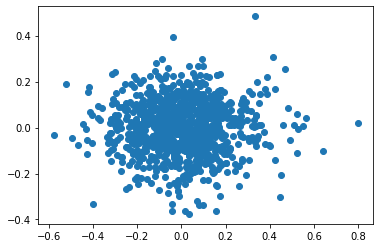

In [41]:
# make word2vec and apply in document 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs = [d for d in books_df['Paragraphs']]
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

vec_size = 50
alpha = 0.025
d2v_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=1,
                dm =1)
d2v_model.build_vocab(documents)
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
d2v=d2v_model.docvecs.doctag_syn0
#print(d2v)
print(d2v.shape)
pca = PCA(n_components=2)
result = pca.fit_transform(d2v)
plt.scatter(result[:, 0], result[:, 1])

## Exploratory Data Analysis

In [42]:
def plot_word_cloud(book1):
  book1_str = [" ".join(doc) for doc in book1]
  
  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(",".join(book1_str).split())
  wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

In [43]:
def plot_word_bar(book): 

  book1_str = [" ".join(doc) for doc in book]
  
  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(",".join(book1_str).split())

  plt.figure(figsize=(15,8))
  plt.bar(range(len(word_could_dict.most_common(20))), [val[1] for val in word_could_dict.most_common(20)], align='center')
  plt.xticks(range(len(word_could_dict.most_common(20))), [val[0] for val in word_could_dict.most_common(20)])
  plt.xticks(rotation=70)
  plt.title("Most Frequent Words")
  plt.xlabel("Word")
  plt.ylabel("Count")
  plt.show()

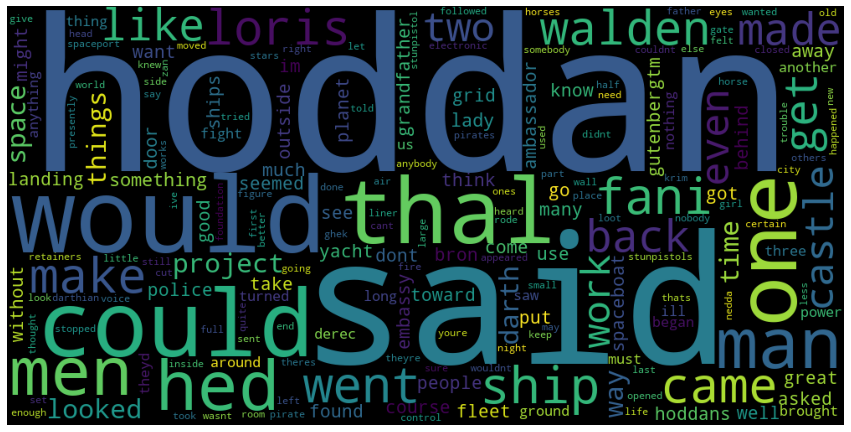

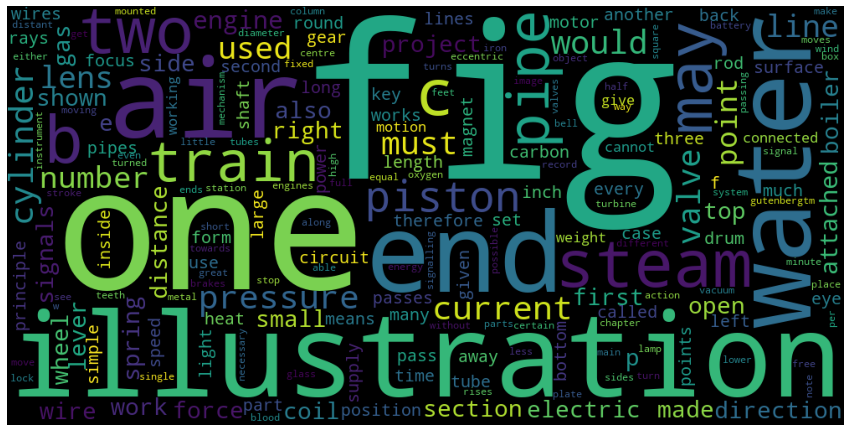

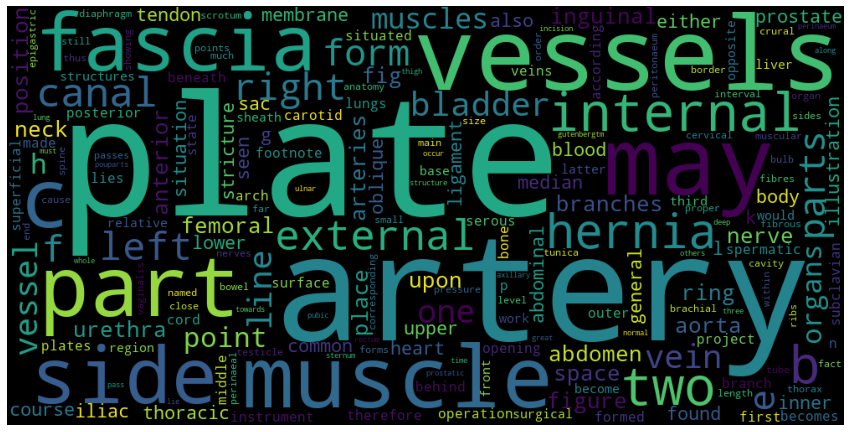

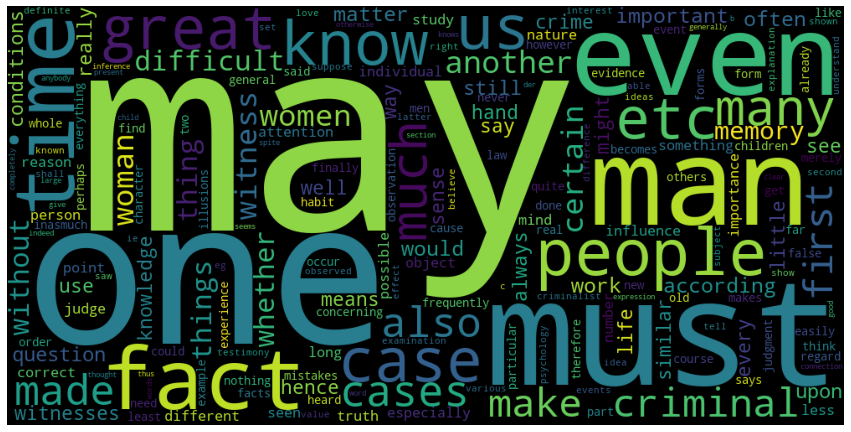

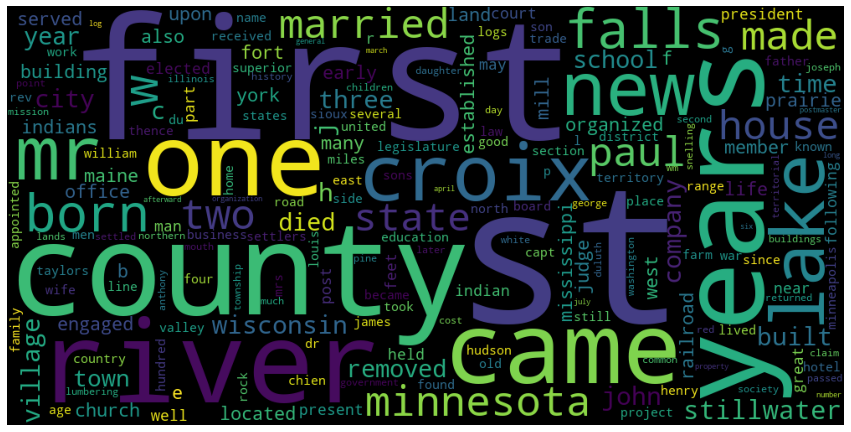

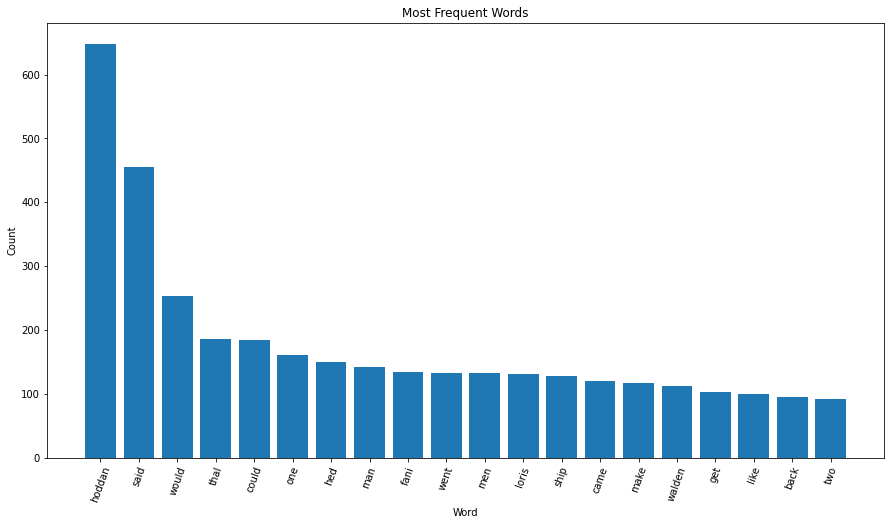

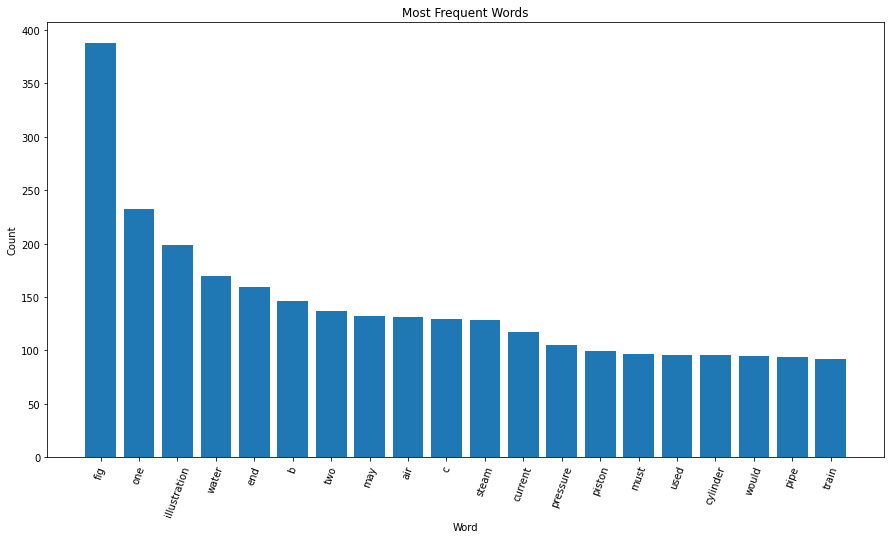

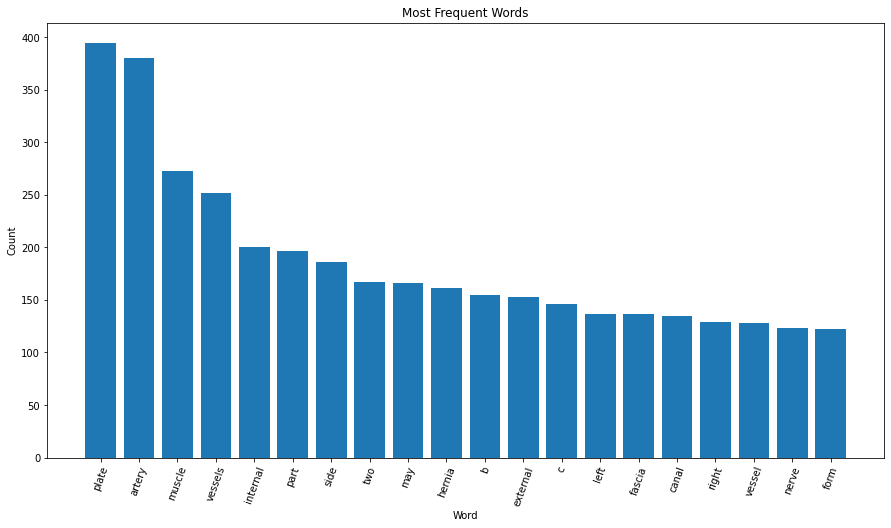

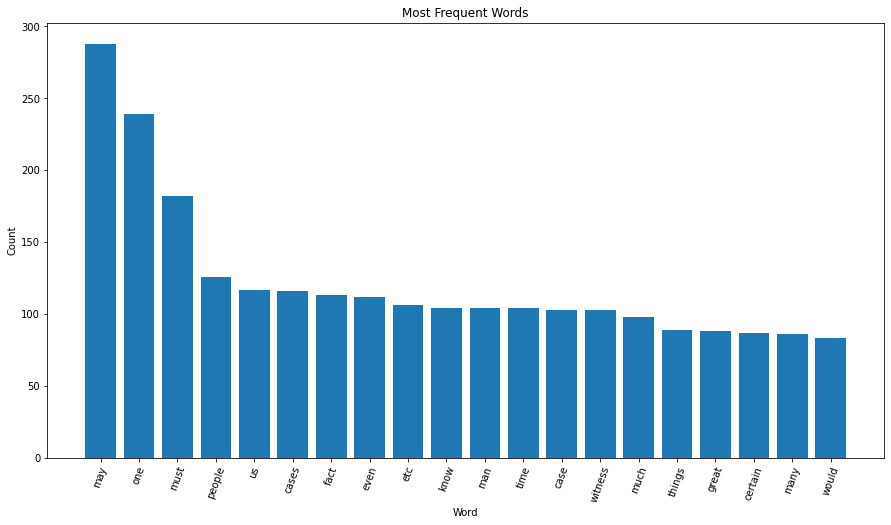

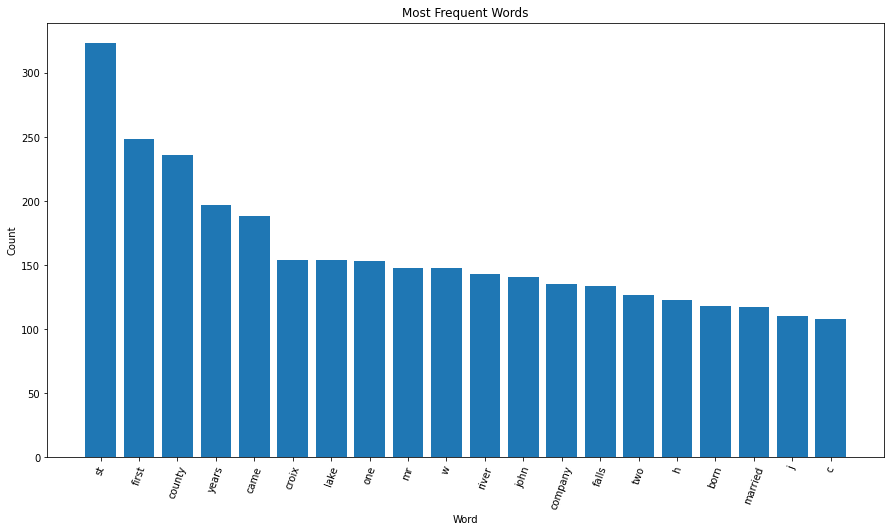

In [44]:
for url in urls:
  plot_word_cloud(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))))
for url in urls:
  plot_word_bar(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))))

### plot model

In [50]:
def plot_BOW(y_predict, title_m ):
      
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 0, 0], BOW_2Dtransformed_data[y_predict == 0, 1], s = 200, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 1, 0], BOW_2Dtransformed_data[y_predict == 1, 1], s = 200, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 2, 0], BOW_2Dtransformed_data[y_predict == 2, 1], s = 200, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 3, 0], BOW_2Dtransformed_data[y_predict == 3, 1], s = 200, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 4, 0], BOW_2Dtransformed_data[y_predict == 4, 1], s = 200, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 0, 0]), np.mean( BOW_2Dtransformed_data[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 1, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 2, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 3, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(BOW_2Dtransformed_data[y_predict == 4, 0]), np.mean(BOW_2Dtransformed_data[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  


In [51]:
def plot_TF_IDF(y_predict, title_m ):
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==0,0], tfidf_2Dtransformed_data[pred_y ==0,1] ,c='magenta' ,label='claster 1')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==1,0], tfidf_2Dtransformed_data[pred_y ==1,1] ,c= 'green',label='claster 1')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==2,0], tfidf_2Dtransformed_data[pred_y ==2,1] ,c= 'blue',label='claster 3')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==3,0], tfidf_2Dtransformed_data[pred_y ==3,1] ,c= 'orange',label='claster 4')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==4,0], tfidf_2Dtransformed_data[pred_y ==4,1] ,c= 'cyan',label='claster 5')
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 0, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 1, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 2, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 3, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
   mtp.plot(np.mean(tfidf_2Dtransformed_data[y_predict == 4, 0]), np.mean(tfidf_2Dtransformed_data[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
   mtp.title(title_m )  
   mtp.legend()  
   mtp.show()  

In [52]:
def plot_LDA(y_predict, title_m ):
      
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 0, 0], LDA_2Dtransformed_data[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 1, 0], LDA_2Dtransformed_data[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 2, 0], LDA_2Dtransformed_data[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 3, 0], LDA_2Dtransformed_data[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 4, 0], LDA_2Dtransformed_data[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 0, 0]), np.mean( LDA_2Dtransformed_data[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 1, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 2, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 3, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(LDA_2Dtransformed_data[y_predict == 4, 0]), np.mean(LDA_2Dtransformed_data[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  

In [53]:

def plot_word__em(y_predict, title_m ):
      
    mtp.scatter(result[y_predict == 0, 0], result[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(result[y_predict == 1, 0], result[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(result[y_predict == 2, 0], result[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(result[y_predict == 3, 0], result[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(result[y_predict == 4, 0], result[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.plot(np.mean(result[y_predict == 0, 0]), np.mean( result[y_predict == 0, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 1, 0]), np.mean(result[y_predict == 1, 1],), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 2, 0]), np.mean(result[y_predict == 2, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 3, 0]), np.mean(result[y_predict == 3, 1]), color='yellow', marker='^', markersize=12)
    mtp.plot(np.mean(result[y_predict == 4, 0]), np.mean(result[y_predict == 4, 1]), color='yellow', marker='^', markersize=12)
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  

# Helmy
---


##K-mean with BOW

In [ ]:
bow__helmy = bag_of_word1
tfidf_helmy = tfidf_df1
helmy_lda =  LDA_out
helmy_word_vec =d2v


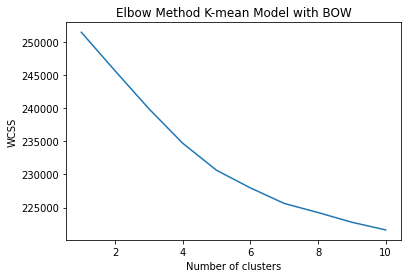

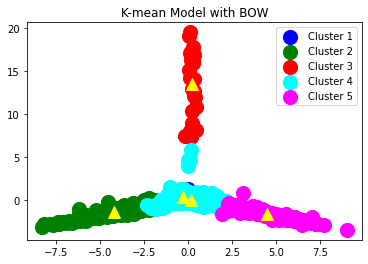



Accuracy equal :->  0.71
              precision    recall  f1-score   support

           a       1.00      0.86      0.93       200
           b       0.99      0.88      0.93       200
           c       0.32      0.04      0.08       200
           d       0.42      0.99      0.59       200
           e       1.00      0.78      0.87       200

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.68      1000
weighted avg       0.75      0.71      0.68      1000

Kappa for the model :->  0.6375
For n_clusters = 5 The average silhouette_score : 0.026480270455698666
For n_clusters = 5 The average homogeneity_score : 0.6207501407501969
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 3 3 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 2 1 1 3 1 2 1 1 1 1
 1 1 1 1 1 

In [ ]:
# applay K-mean with BOW
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=40, random_state=7)
    kmeans.fit(bow__helmy)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with BOW')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=140, random_state=7)
pred_y= kmeans.fit_predict(bow__helmy)  
plot_BOW( pred_y ,'K-mean Model with BOW')
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(2)
  elif yy[i]=="c":
    x.append(4)
  elif yy[i]=="d":
    x.append(3)
  else :
    x.append(0)

print("Accuracy equal :-> ",np.mean(pred_y == x))
print(metrics.classification_report( x , pred_y,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))
silhouette_avg = silhouette_score(bow__helmy,pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 

print(pred_y)

##K-mean with TF-IDF 

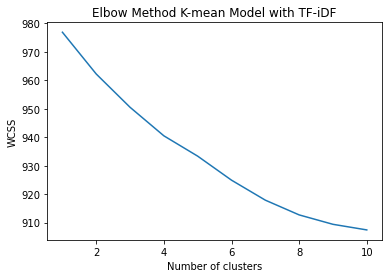

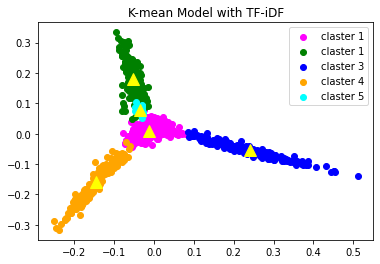



Accuracy equal :->  0.38
              precision    recall  f1-score   support

           a       0.47      0.99      0.64       200
           b       0.00      0.00      0.00       200
           c       1.00      0.91      0.95       200
           d       0.00      0.00      0.00       200
           e       0.00      0.00      0.00       200

    accuracy                           0.38      1000
   macro avg       0.29      0.38      0.32      1000
weighted avg       0.29      0.38      0.32      1000

Kappa for the model :->  0.22499999999999998
For n_clusters = 5 The average silhouette_score : 0.02497601560160803
For n_clusters = 5 The average homogeneity_score : 0.7343923017823558
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 3 3 3 3
 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3
 3 3 3 4 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

In [55]:
# apply the k-mean on TF-IDF data transformation 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_helmy)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with TF-iDF')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=150, random_state=7)
pred_y = kmeans.fit_predict(tfidf_helmy)
plot_TF_IDF( pred_y ,'K-mean Model with TF-iDF')
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(3)
  elif yy[i]=="c":
    x.append(2)
  elif yy[i]=="d":
    x.append(0)
  else :
    x.append(4)
#print(yy )
#print(y_prediction )

print("Accuracy equal :-> ",metrics.accuracy_score(pred_y,x))
print(metrics.classification_report( x , pred_y,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))

silhouette_avg = silhouette_score(tfidf_helmy , pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 

print(kmeans.labels_)


##k-mean with lda

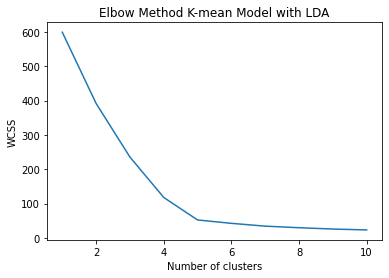

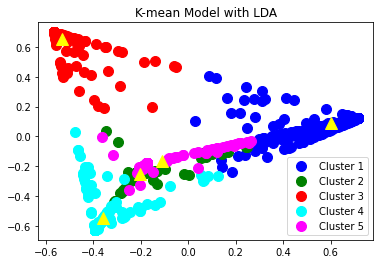



Accuracy equal :->  0.2
              precision    recall  f1-score   support

           a       0.54      0.94      0.68       200
           b       0.04      0.03      0.03       200
           c       0.00      0.00      0.00       200
           d       0.01      0.01      0.01       200
           e       0.04      0.03      0.03       200

    accuracy                           0.20      1000
   macro avg       0.12      0.20      0.15      1000
weighted avg       0.12      0.20      0.15      1000

Kappa for the model :->  0.0
For n_clusters = 5 The average silhouette_score : 0.015540570629956086
For n_clusters = 5 The average homogeneity_score : 0.6934692766067876
[1 1 1 4 4 4 4 4 1 1 1 1 4 4 1 1 1 4 1 4 1 1 1 1 4 1 1 1 1 1 4 1 1 1 1 1 1
 1 4 4 1 4 4 4 4 1 4 4 1 4 1 1 1 1 4 4 1 1 4 4 1 1 4 1 1 4 4 4 4 1 4 1 4 4
 1 4 1 1 4 4 4 4 4 4 4 1 1 4 1 4 1 1 1 4 4 1 1 1 1 4 4 1 1 1 1 4 1 4 4 4 4
 1 1 1 1 1 1 1 4 4 1 4 1 1 4 1 1 4 1 1 1 1 1 4 1 4 1 4 4 1 1 1 1 1 1 1 1 1
 4 4 1 1 4 4 4 

In [56]:
# apply the k-mean on lad data transformation 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(helmy_lda)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with LDA')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=150, random_state=7)
pred_y = kmeans.fit_predict(helmy_lda)

plot_LDA( pred_y ,'K-mean Model with LDA')
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(2)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(3)
  elif yy[i]=="d":
    x.append(1)
  else :
    x.append(4)

print("Accuracy equal :-> ",metrics.accuracy_score(pred_y,x))
print(metrics.classification_report( x , pred_y,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))

silhouette_avg = silhouette_score(tfidf_helmy , pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 

print(pred_y)


##k-mean with word to vec

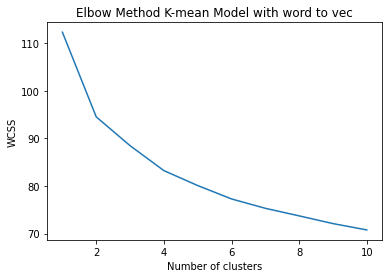

[1 1 4 3 1 4 1 4 1 4 4 4 3 2 3 1 0 0 4 0 3 4 3 1 2 4 1 3 0 0 1 0 1 1 0 4 3
 0 0 4 0 0 0 2 1 1 0 4 0 0 1 0 0 1 0 0 3 2 1 0 4 0 3 0 3 2 1 2 4 1 2 0 1 1
 4 3 2 4 4 2 2 1 3 4 2 0 3 2 0 2 0 4 1 0 4 1 0 0 2 4 4 1 0 3 3 1 1 1 3 2 2
 1 0 0 0 0 0 3 1 2 1 1 0 1 2 0 0 1 1 1 0 0 1 2 1 0 4 0 4 2 1 0 3 3 4 0 3 3
 1 2 3 4 0 1 4 0 3 3 4 1 1 0 2 2 4 1 1 4 1 1 3 1 1 4 0 0 1 0 0 2 4 2 1 4 2
 2 1 1 3 4 0 2 1 1 1 3 3 2 4 0 2 2 2 2 1 1 4 4 4 2 2 2 1 2 4 2 2 4 2 1 0 2
 2 1 2 4 0 2 1 3 1 2 1 0 2 2 2 1 0 1 3 1 0 4 1 4 1 3 1 1 4 0 4 1 0 2 1 1 4
 1 2 4 2 4 1 3 0 2 4 1 0 2 4 0 1 2 1 2 1 1 3 2 0 0 2 1 2 1 0 3 0 1 3 1 2 3
 3 4 0 4 4 0 4 4 1 4 1 2 2 0 1 0 4 0 1 3 2 0 4 0 0 1 2 4 0 2 1 4 3 0 0 4 1
 3 2 1 0 3 1 4 1 1 4 2 1 4 0 3 1 1 3 1 4 4 3 1 2 4 1 4 3 1 3 4 1 2 1 1 4 3
 1 0 3 0 1 2 4 2 3 1 2 1 2 4 0 0 0 1 2 2 3 0 1 0 3 4 1 0 4 2 2 2 2 0 1 2 2
 4 4 2 2 1 0 2 1 4 4 2 1 4 1 4 1 4 1 2 4 2 0 2 1 1 2 2 1 4 2 2 1 4 2 1 4 0
 1 0 1 0 0 2 0 0 1 2 4 4 1 0 1 1 1 0 4 1 1 2 4 1 1 0 4 3 1 4 4 0 2 0 2 1 2
 1 0 4 1 0 1 0 0 1 1 2 1 

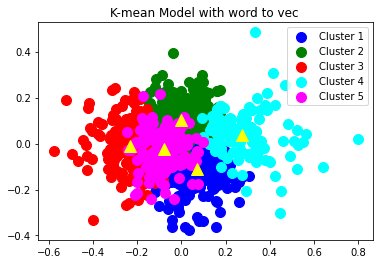



Accuracy equal :->  0.249
              precision    recall  f1-score   support

           a       0.23      0.28      0.25       200
           b       0.40      0.28      0.33       400
           c       0.25      0.23      0.24       200
           d       0.00      0.00      0.00         0
           e       0.22      0.17      0.19       200

    accuracy                           0.25      1000
   macro avg       0.22      0.19      0.20      1000
weighted avg       0.30      0.25      0.27      1000

Kappa for the model :->  0.026445423904589038
For n_clusters = 5 The average silhouette_score : 0.08034058
For n_clusters = 5 The average homogeneity_score : 0.018846389928932637


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
# apply the k-mean on word to vec data transformation 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(helmy_word_vec)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method K-mean Model with word to vec')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=50, random_state=7)
pred_y = kmeans.fit_predict(helmy_word_vec)
print(pred_y)
plot_word__em( pred_y ,'K-mean Model with word to vec ')
#model_accuricy(helmy_word_vec,y_predict)
# get accuricy of model
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(1)
  elif yy[i]=="b":
    x.append(2)
  elif yy[i]=="c":
    x.append(4)
  elif yy[i]=="d":
    x.append(0)
  else :
    x.append(1)
#print(yy )
#print(y_prediction )

print("Accuracy equal :-> ",metrics.accuracy_score(pred_y,x))
print(metrics.classification_report( x , pred_y,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(pred_y,x))

silhouette_avg = silhouette_score(helmy_word_vec , pred_y)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,pred_y)) 


# Sameh
---


In [58]:
bow__sameh = bag_of_word1
fidf_sameh = tfidf_df1
lda_sameh = LDA_out
sameh_word_vec =d2v

In [59]:
# apply GaussianMixture on BOW on and make predicton 
def EM_model(X):
  n_components = np.arange(1, 10)
  models = [GaussianMixture(n, covariance_type='diag', random_state=0).fit(X) for n in n_components]
  plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
  plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
  plt.legend(loc='best')
  plt.xlabel('n_components');
  plt.show()  

  GM = GaussianMixture(n_components=5, covariance_type='spherical', random_state=7)
  GM.fit(X)

  y_pred = GM.predict(X)
  return y_pred


###apply GaussianMixture on BOW on and make predicton

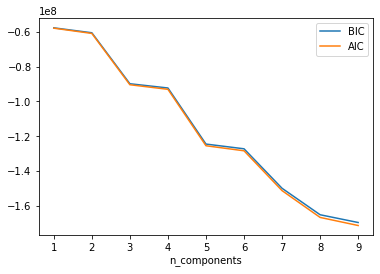

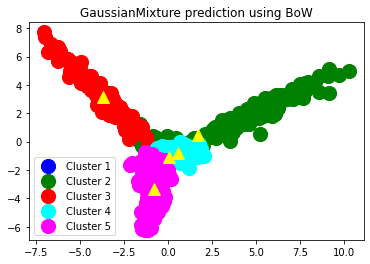



Accuracy equal :->  0.204
              precision    recall  f1-score   support

           a       1.00      0.01      0.01       200
           b       0.45      1.00      0.62       200
           c       0.00      0.00      0.00       200
           d       0.02      0.01      0.02       200
           e       0.00      0.00      0.00       200

    accuracy                           0.20      1000
   macro avg       0.29      0.20      0.13      1000
weighted avg       0.29      0.20      0.13      1000

Kappa for the model :->  0.0050000000000000044
For n_clusters = 5 The average silhouette_score : 0.01259153275114346
For n_clusters = 5 The average homogeneity_score : 0.6991657696318083
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [60]:
label = EM_model(bow__sameh)
plot_BOW(label , 'GaussianMixture prediction using BoW' )
#model_accuricy(bow__sameh ,label)
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(4)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(3)
#print(yy )
#print(y_prediction )

print("Accuracy equal :-> ",metrics.accuracy_score(label,x))
print(metrics.classification_report( x , label,target_names= names ))

print("Kappa for the model :-> " , cohen_kappa_score(label,x))

silhouette_avg = silhouette_score(bow__sameh , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)


###apply GaussianMixture on TF-IDF on and make predicton 

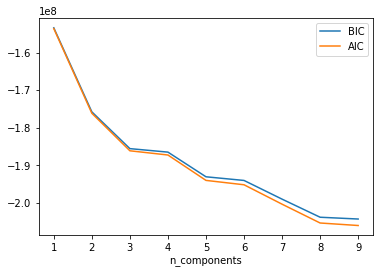

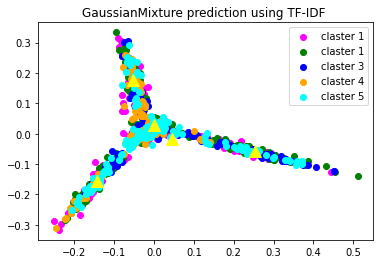



Accuracy equal :->  0.494
              precision    recall  f1-score   support

           a       0.91      0.99      0.95       200
           b       0.34      0.51      0.40       200
           c       0.00      0.00      0.00       200
           d       0.00      0.00      0.00       200
           e       0.99      0.97      0.98       200

    accuracy                           0.49      1000
   macro avg       0.45      0.49      0.47      1000
weighted avg       0.45      0.49      0.47      1000

Kappa for the model :->  0.36750000000000005
For n_clusters = 5 The average silhouette_score : 0.019398382161122222
For n_clusters = 5 The average homogeneity_score : 0.8003898916306251
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2
 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [61]:
# apply GaussianMixture on TF-IDF on and make predicton 
label =EM_model(fidf_sameh)
plot_TF_IDF(label , 'GaussianMixture prediction using TF-IDF ' )

# get accurecy
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()

for i in range(1000):

  if yy[i]=="a":
    x.append(3)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(4)

print("Accuracy equal :-> ",metrics.accuracy_score(label,x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(fidf_sameh , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

### apply GaussianMixture on LDA data  on and make predicton 


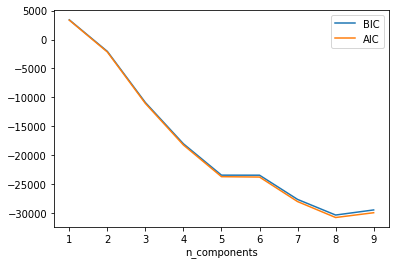

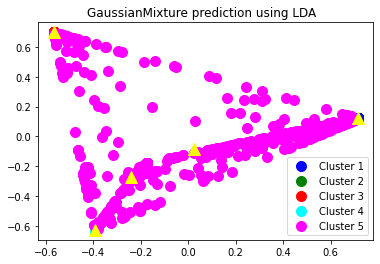



Accuracy equal :->  0.208
              precision    recall  f1-score   support

           a       0.58      0.47      0.52       200
           b       0.00      0.00      0.00       200
           c       0.00      0.00      0.00       200
           d       0.00      0.00      0.00       200
           e       0.21      0.57      0.30       200

    accuracy                           0.21      1000
   macro avg       0.16      0.21      0.17      1000
weighted avg       0.16      0.21      0.17      1000

Kappa for the model :->  0.010000000000000009
For n_clusters = 5 The average silhouette_score : 0.20516397664965758
For n_clusters = 5 The average homogeneity_score : 0.3857033444078168
[1 1 4 4 4 4 4 4 1 4 4 4 4 4 4 1 1 4 4 4 4 1 4 1 4 4 4 1 4 1 4 1 4 1 4 4 1
 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4
 4 4 1 4 4 4 4 4 4 4 4 1 1 4 1 4 1 1 1 4 4 1 4 1 1 4 4 1 4 4 1 4 4 4 4 4 4
 1 4 4 4 1 1 1 4 4 4 4 1 1 4 1 1 4 1 4 1 4 1 4 4 4 4 4 4 4 1 1 4 1 1 1 4

In [62]:
# apply GaussianMixture on LDA data  on and make predicton 
label = EM_model(lda_sameh)
plot_LDA(label , 'GaussianMixture prediction using LDA  ' )

# get accurecy
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(2)
  elif yy[i]=="b":
    x.append(0)
  elif yy[i]=="c":
    x.append(3)
  elif yy[i]=="d":
    x.append(1)
  else :
    x.append(4)

print("Accuracy equal :-> ",metrics.accuracy_score(label,x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(lda_sameh , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

###apply GaussianMixture on word embeded on and make predicton 

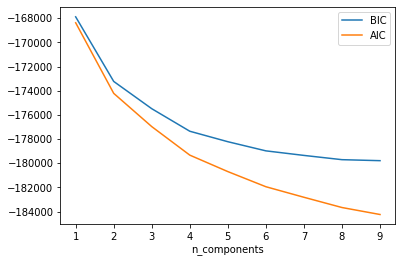

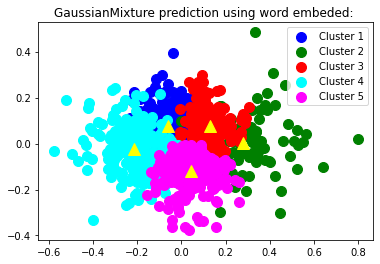



Accuracy equal :->  0.161
              precision    recall  f1-score   support

           a       0.21      0.28      0.24       200
           b       0.10      0.06      0.07       200
           c       0.19      0.16      0.17       200
           d       0.13      0.14      0.13       200
           e       0.14      0.17      0.15       200

    accuracy                           0.16      1000
   macro avg       0.15      0.16      0.15      1000
weighted avg       0.15      0.16      0.15      1000

Kappa for the model :->  -0.04875000000000007
For n_clusters = 5 The average silhouette_score : 0.058313645
For n_clusters = 5 The average homogeneity_score : 0.022984104436237895
[0 2 0 2 0 3 2 0 0 4 4 4 1 3 2 2 4 4 3 4 1 4 1 2 3 3 2 2 4 4 0 2 0 2 4 3 2
 2 4 3 4 4 4 0 0 2 4 0 4 4 0 2 4 0 2 4 2 3 0 4 0 2 2 4 2 3 0 3 3 0 0 4 0 0
 2 2 0 0 4 3 3 2 1 0 0 4 1 3 4 3 4 4 2 1 0 0 2 4 0 0 4 0 4 2 2 2 0 0 2 3 0
 0 4 2 4 4 4 2 2 3 0 2 4 2 0 4 4 0 2 2 4 4 0 3 0 4 1 4 3 3 0 4 2 2 4 4 2 2
 0 

In [63]:
# apply GaussianMixture on word embeded on and make predicton 
label = EM_model(sameh_word_vec)
plot_word__em(label , 'GaussianMixture prediction using word embeded: ' )
# get accurecy of the model 
names =['a', 'b', 'c', 'd', 'e']
print("\n")
x=[]
y = books_df.iloc[:,1]
yy = y.tolist()
for i in range(1000):
  if yy[i]=="a":
    x.append(0)
  elif yy[i]=="b":
    x.append(4)
  elif yy[i]=="c":
    x.append(1)
  elif yy[i]=="d":
    x.append(2)
  else :
    x.append(3)

print("Accuracy equal :-> ",np.mean(label == x))
print(metrics.classification_report( x , label,target_names= names ))
print("Kappa for the model :-> " , cohen_kappa_score(label,x))
silhouette_avg = silhouette_score(sameh_word_vec , label)
print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
print("For n_clusters =", 5,"The average homogeneity_score :", homogeneity_score(x,label)) 
print(label)

### plot model

In [64]:
def plot_BOW(y_predict, title_m ):
      
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 0, 0], BOW_2Dtransformed_data[y_predict == 0, 1], s = 200, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 1, 0], BOW_2Dtransformed_data[y_predict == 1, 1], s = 200, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 2, 0], BOW_2Dtransformed_data[y_predict == 2, 1], s = 200, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 3, 0], BOW_2Dtransformed_data[y_predict == 3, 1], s = 200, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(BOW_2Dtransformed_data[y_predict == 4, 0], BOW_2Dtransformed_data[y_predict == 4, 1], s = 200, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroid')   
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  


In [65]:
def plot_TF_IDF(y_predict, title_m ):
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==0,0], tfidf_2Dtransformed_data[pred_y ==0,1] ,c='magenta' ,label='claster 1')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==1,0], tfidf_2Dtransformed_data[pred_y ==1,1] ,c= 'green',label='claster 1')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==2,0], tfidf_2Dtransformed_data[pred_y ==2,1] ,c= 'blue',label='claster 3')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==3,0], tfidf_2Dtransformed_data[pred_y ==3,1] ,c= 'orange',label='claster 4')
   mtp.scatter(tfidf_2Dtransformed_data[pred_y ==4,0], tfidf_2Dtransformed_data[pred_y ==4,1] ,c= 'cyan',label='claster 5')
   mtp.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', label='centers')  
   mtp.title(title_m )  
   mtp.legend()  
   mtp.show()  

In [66]:
def plot_LDA(y_predict, title_m ):
      
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 0, 0], LDA_2Dtransformed_data[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 1, 0], LDA_2Dtransformed_data[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 2, 0], LDA_2Dtransformed_data[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 3, 0], LDA_2Dtransformed_data[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(LDA_2Dtransformed_data[y_predict == 4, 0], LDA_2Dtransformed_data[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroid')   
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  

In [67]:

def plot_word__em(y_predict, title_m ):
      
    mtp.scatter(result[y_predict == 0, 0], result[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    mtp.scatter(result[y_predict == 1, 0], result[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    mtp.scatter(result[y_predict == 2, 0], result[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    mtp.scatter(result[y_predict == 3, 0], result[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    mtp.scatter(result[y_predict == 4, 0], result[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    mtp.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroid')   
    mtp.title(title_m )  

    mtp.legend()  
    mtp.show()  

#### get model accuricy

In [68]:
# def model_accuricy(data ,y_prediction ):


#   names =['a', 'b', 'c', 'd', 'e']
#   print("\n")
#   x=[]
#   y = books_df.iloc[:,1]
#   yy = y.tolist()

#   for i in range(1000):

#     if yy[i]=="a":
#       x.append(4)
#     elif yy[i]=="b":
#       x.append(1)
#     elif yy[i]=="c":
#       x.append(3)
#     elif yy[i]=="d":
#       x.append(2)
#     else :
#       x.append(0)
#   #print(yy )
#   #print(y_prediction )

#   print("Accuracy equal :-> ",np.mean(y_prediction == x))
#   print(metrics.classification_report( x , y_prediction,target_names= names ))

#   print("Kappa for the model :-> " , cohen_kappa_score(y_prediction,x))

#   silhouette_avg = silhouette_score(data , y_prediction)
#   print("For n_clusters =", 5,"The average silhouette_score :", silhouette_avg) 
#   #coherance = getcoherance(data ,y_prediction)
#   #print("For n_clusters =", 5,"The coherance score equal : ", coherance)

#   # 0>> means overlapped clusters



###get coherance of the cluster of model and  true data to make evaluation 

In [69]:
from gensim.corpora.dictionary import Dictionary

from gensim.models.coherencemodel import CoherenceModel


book_doc = books_df['Paragraphs'].values.tolist()
doc_list =[]
for doc in book_doc:
  doc_list.append(doc.split())
print(doc_list)
# Create a dictionary representation of the documents.
dictionary = Dictionary(doc_list)
dictionary.filter_extremes(no_below=10, no_above=0.2)
print(dictionary)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(bag_of_word1) for doc in doc_list]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

#cm = CoherenceModel( topics= y_predct,corpus=corpus,dictionary=dictionary,coherence='u_mass')
#print(cm.get_coherence()) 
#2682

[['pounded', 'head', 'tiny', 'troop', 'second', 'time', 'life', 'hed', 'horse', 'two', 'many', 'adventure', 'exhilarating', 'came', 'mind', 'depressingly', 'supposedly', 'stirring', 'action', 'like', 'really', 'satisfying', 'piracy', 'fani', 'tricked', 'fix', 'fight', 'ghek', 'disgracedand', 'disgraced', 'darth', 'equivalent', 'suicide', 'horse', 'came', 'gentle', 'rise', 'ground', 'grew', 'steeper', 'horse', 'slacked', 'galloping', 'incline', 'grew', 'steeper', 'still', 'horse', 'slowed', 'walk', 'pursued', 'rhythmically', 'tossing', 'head', 'less', 'uncomfortable', 'gallop', 'dim', 'outline', 'trees', 'appeared', 'overhead', 'perfect', 'place', 'ambush', 'hoddan', 'reflected', 'dourly', 'got', 'stunpistol', 'set', 'stud', 'continuous', 'firesomething', 'hadnt', 'dared', 'trust', 'others', 'horse', 'breasted', 'rise', 'yell', 'ahead', 'dim', 'figures', 'plunged', 'toward', 'painstakingly', 'made', 'ready', 'swing', 'stunpistol', 'extreme', 'right', 'across', 'space', 'way', 'extreme',

# Mostafa
---


## Exploratory Data Analysis

In [70]:
from wordcloud import WordCloud
from collections import Counter
from scipy import sparse

In [71]:
def plot_word_cloud(book1):
  book1_str = [" ".join(doc) for doc in book1]
  
  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(",".join(book1_str).split())
  wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

In [72]:
def plot_word_bar(book): 

  book1_str = [" ".join(doc) for doc in book]
  
  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(",".join(book1_str).split())

  plt.figure(figsize=(15,8))
  plt.bar(range(len(word_could_dict.most_common(10))), [val[1] for val in word_could_dict.most_common(10)], align='center')
  plt.xticks(range(len(word_could_dict.most_common(10))), [val[0] for val in word_could_dict.most_common(10)])
  plt.xticks(rotation=70)
  plt.title("Most Frequent Words")
  plt.xlabel("Word")
  plt.ylabel("Count")
  plt.show()

In [78]:
def plot_word_bar_one_paragraph(book): 

  # book1_str = [" ".join(doc) for doc in book]
  book1_str = book

  #convert it to dictionary with values and its occurences
  word_could_dict=Counter(book1_str.split())

  plt.figure(figsize=(15,8))
  plt.bar(range(len(word_could_dict.most_common(10))), [val[1] for val in word_could_dict.most_common(10)], align='center')
  plt.xticks(range(len(word_could_dict.most_common(10))), [val[0] for val in word_could_dict.most_common(10)])
  plt.xticks(rotation=70)
  plt.title("Most Frequent Words")
  plt.xlabel("Word")
  plt.ylabel("Count")
  plt.show()

In [79]:
# for url in urls:
#   plot_word_cloud(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))))

In [80]:
# for url in urls:
#   plot_word_bar(split_book(remove_stopwords(remove_numbers(remove_punct(get_book(url))))))

## Hierarchy

#### Import Libraries

In [81]:
from scipy import ndimage 
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics.pairwise import euclidean_distances
from gensim.models.doc2vec import Doc2Vec
from scipy import sparse
import pylab

%matplotlib inline

In [82]:
#bag_of_word1

In [83]:
#tfidf_df1

#### Hierarchy Functions

In [84]:
def dist_matrix(features):
  dist_matrix = euclidean_distances(features, features) 
  Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')
  return Z_using_dist_matrix  

def draw_dendo(Z_using_dist_matrix):  
  fig = pylab.figure(figsize=(18,50))
  dendro = hierarchy.dendrogram(Z_using_dist_matrix, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [85]:
# def agglom_model(dist_mat, n_clusters): 
#   agglom = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'complete')
#   model = agglom.fit(dist_mat)

#   return model

##### Transformation Functions

In [86]:
def bow_transform(corpus):
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(corpus)
    return X, vectorizer

In [87]:
def tfidf_transform(corpus):
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(corpus)
    return X, vectorizer

In [88]:
def lda_transform(corpus):
  vectorizer = LatentDirichletAllocation(n_components = 10, max_iter=10, n_jobs = -1, batch_size=128, learning_decay=0.5, random_state=0)
  X = vectorizer.fit_transform(corpus)  
  return sparse.csr_matrix(X), vectorizer

In [89]:
def d2v_transform(corpus):
  docs = [d for d in corpus]
  tags_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

  d2v_model = Doc2Vec(vector_size=50,
                  alpha=0.025, 
                  min_alpha=0.0025,
                  min_count=1,
                  dm =1)
  d2v_model.build_vocab(tags_docs)
  d2v_model.train(tags_docs, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
  d2v=d2v_model.docvecs.doctag_syn0
  
  return d2v

In [90]:


docs = [d for d in books_df['Paragraphs']]
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]

vec_size = 50
alpha = 0.025
d2v_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=1,
                dm =1)
d2v_model.build_vocab(documents)
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
d2v=d2v_model.docvecs.doctag_syn0

##### Plot Functions

In [91]:
def plot_clusters(transform_model, cluster_model, y, n=5):
    # PCA for Transformation model
    pca_model = PCA(n_components=2).fit_transform(transform_model.toarray())
    
    plt.figure(figsize=(17,6))
    
    plt.subplot(1,2,1)
    for clstr in range(n):
        x_points_org = pca_model[y == clstr, 0]
        y_points_org = pca_model[y == clstr, 1]
        plt.scatter(x_points_org, y_points_org, label='Book '+str(clstr+1))
        plt.plot(np.mean(x_points_org), np.mean(y_points_org), color='yellow', marker='^', markersize=12)
    
    plt.title("Original Data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    
    plt.subplot(1,2,2)
    for clstr in range(n):
        x_points = pca_model[cluster_model.fit_predict(pca_model) == clstr, 0]
        y_points = pca_model[cluster_model.fit_predict(pca_model) == clstr, 1]
        plt.scatter(x_points, y_points, label="Cluster "+str(clstr+1))
        plt.plot(np.mean(x_points), np.mean(y_points), color='yellow', marker='^', markersize=12)
    
    plt.title("Clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend();

In [92]:
def plot_clusters_tsne(transform_model, cluster_model, y, n=5):
    # T-SNE for Transformation model
    tsne_obj = TSNE(n_components=2)
    tsne_model = tsne_obj.fit_transform(transform_model.toarray())
    
    plt.figure(figsize=(17,6))
    
    plt.subplot(1,2,1)
    for clstr in range(n):
        x_points_org = tsne_model[y == clstr, 0]
        y_points_org = tsne_model[y == clstr, 1]
        plt.scatter(x_points_org, y_points_org, label='Book '+str(clstr+1))
        plt.plot(np.mean(x_points_org), np.mean(y_points_org), color='yellow', marker='^', markersize=12)
    
    plt.title("Original Data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    
    plt.subplot(1,2,2)
    for clstr in range(n):
        x_points = tsne_model[cluster_model.fit_predict(tsne_model) == clstr, 0]
        y_points = tsne_model[cluster_model.fit_predict(tsne_model) == clstr, 1]
        plt.scatter(x_points, y_points, label="Cluster "+str(clstr+1))
        plt.plot(np.mean(x_points), np.mean(y_points), color='yellow', marker='^', markersize=12)
    
    plt.title("Clusters")
    plt.xlabel("TSNE1")
    plt.ylabel("TSNE2")
    plt.legend();

In [93]:
def cluster_count(cluster_model):
  unique, counts = np.unique(cluster_model.labels_, return_counts=True)
  print(np.asarray((unique, counts)).T)
  
  plt.figure(figsize=(8,6))
  plt.bar(unique,counts)
  plt.title("Clusters Count")
  plt.xlabel("Cluster")
  plt.ylabel("Count")
  plt.show()

##### Metrics Functions

In [94]:
def calc_scores(transformation_model, clustering_model, y):
  silh = silhouette_score(transformation_model.toarray(), clustering_model.fit_predict(transformation_model.toarray()))
  kap = cohen_kappa_score(y, clustering_model.labels_)

  print("Silhouette Coefficient is:", round(silh, 4))
  print("Cohen’s kappa Score is:", round(kap, 4))

In [95]:
books_df['label_num'] = books_df.Label.map({'a':0, 'b':1, 'c':2, 'd':3, 'e':4})
y = books_df.label_num

#### BoW

In [96]:
bow_model, bow_vectorizer = bow_transform(books_df.Paragraphs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


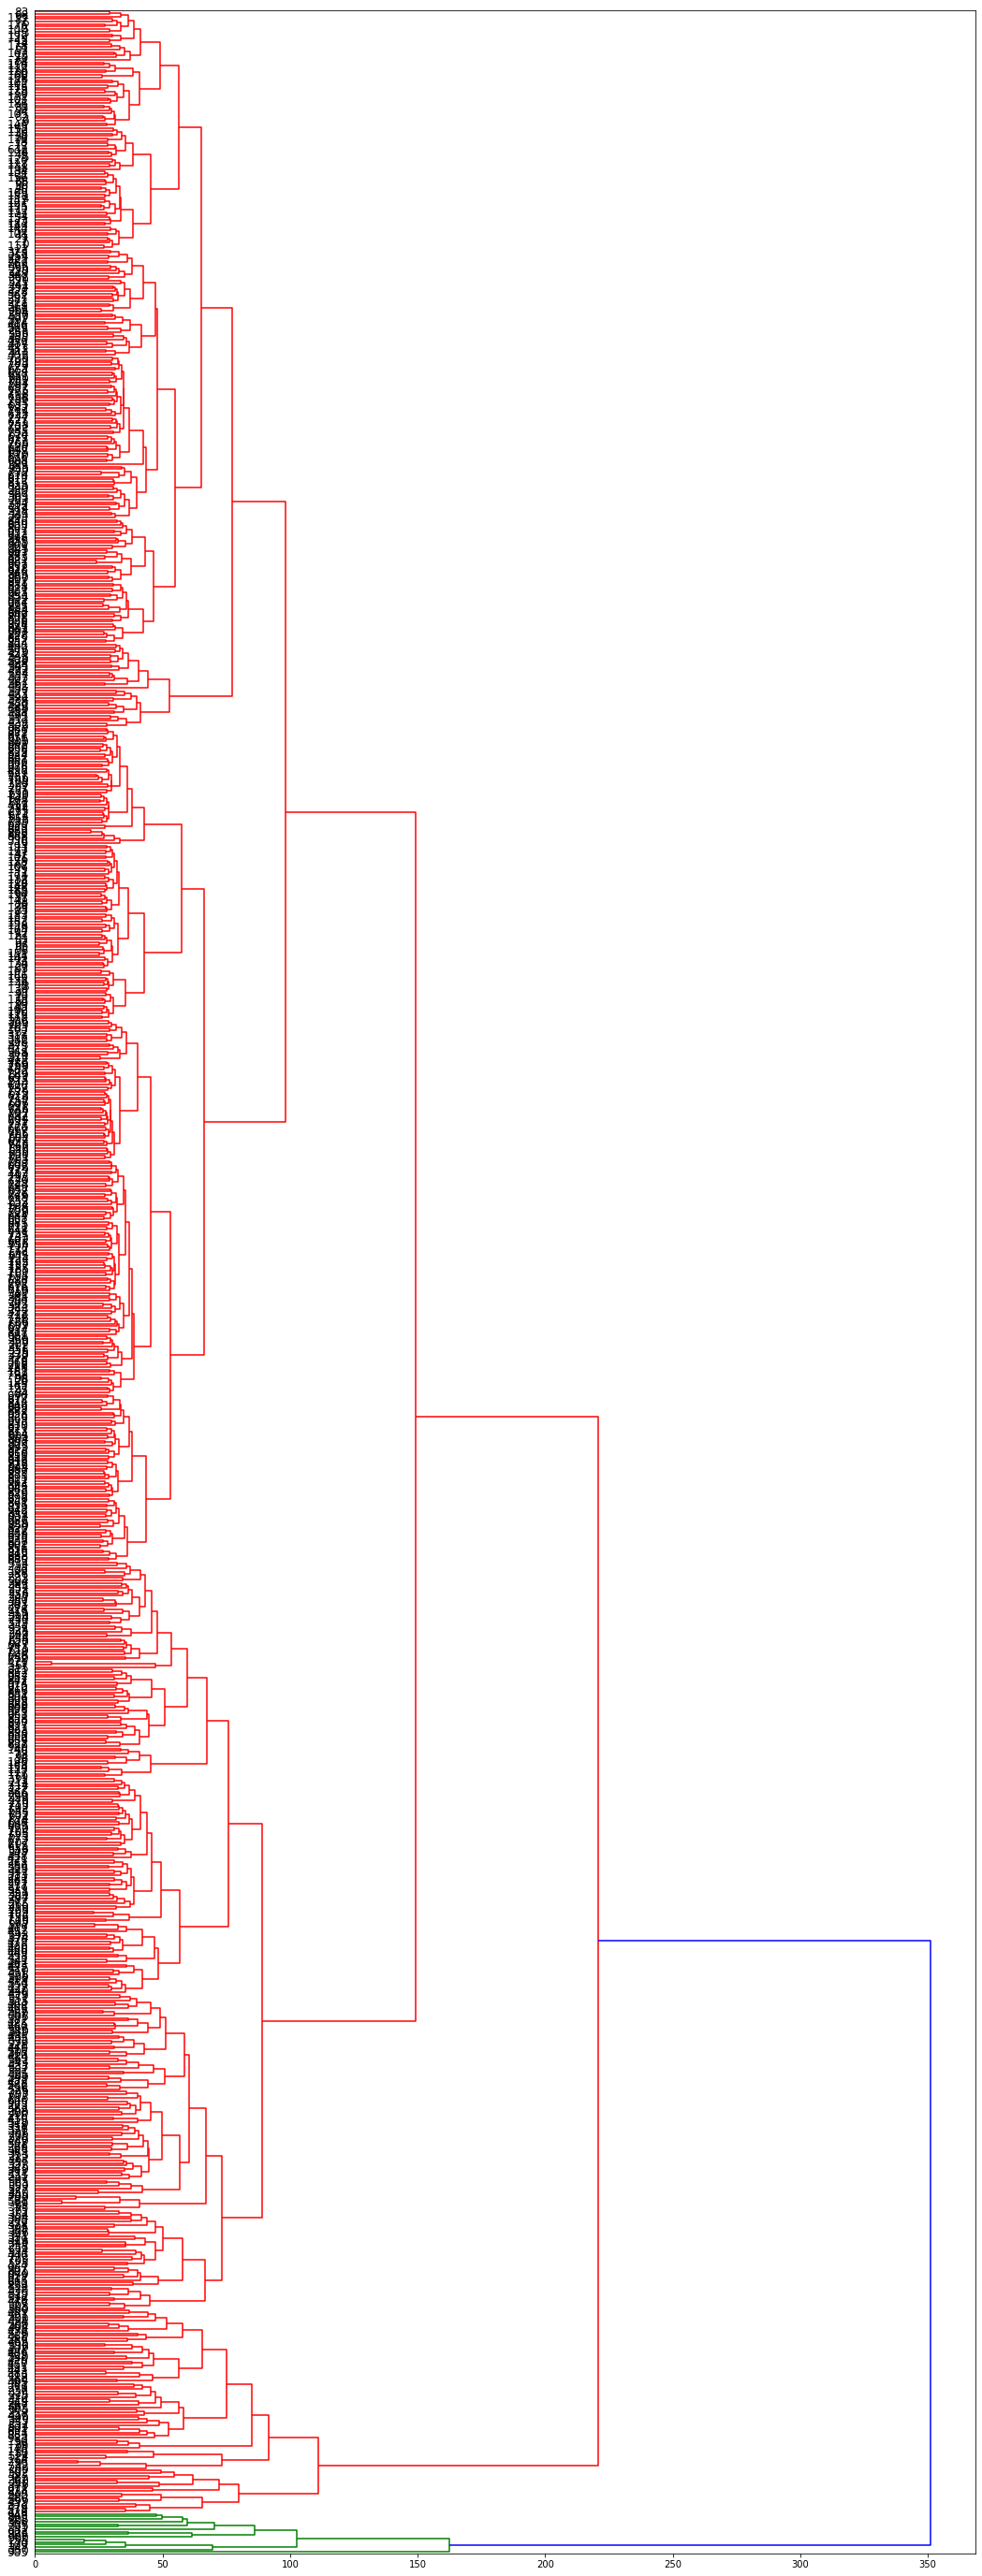

In [97]:
draw_dendo(dist_matrix(bow_model))

In [98]:
agg_bow_model = AgglomerativeClustering(n_clusters=5).fit(bow_model.toarray(), y)
agg_bow_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

[[  0 399]
 [  1 191]
 [  2 191]
 [  3 199]
 [  4  20]]


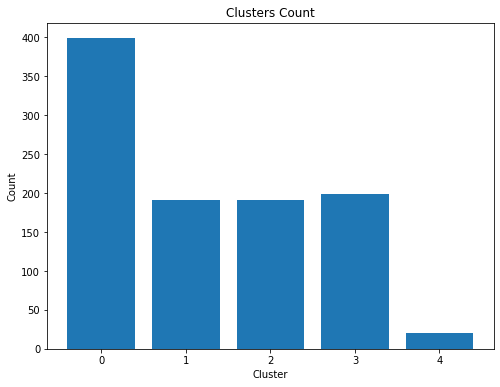

In [99]:
cluster_count(agg_bow_model)

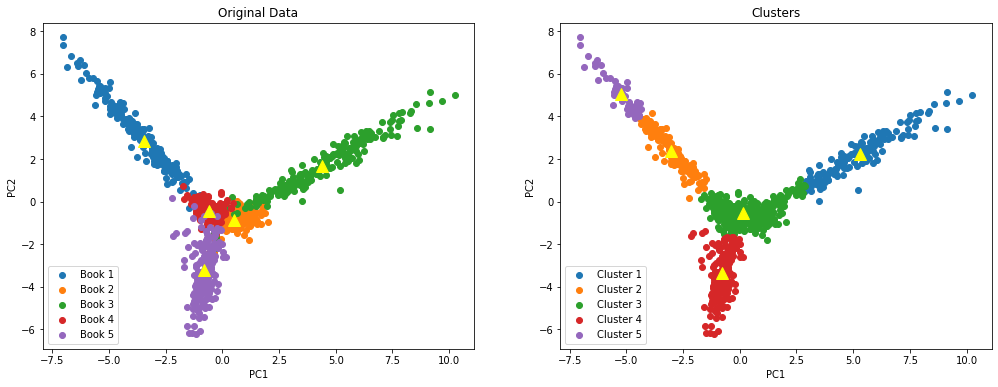

In [100]:
plot_clusters(bow_model, agg_bow_model, y)

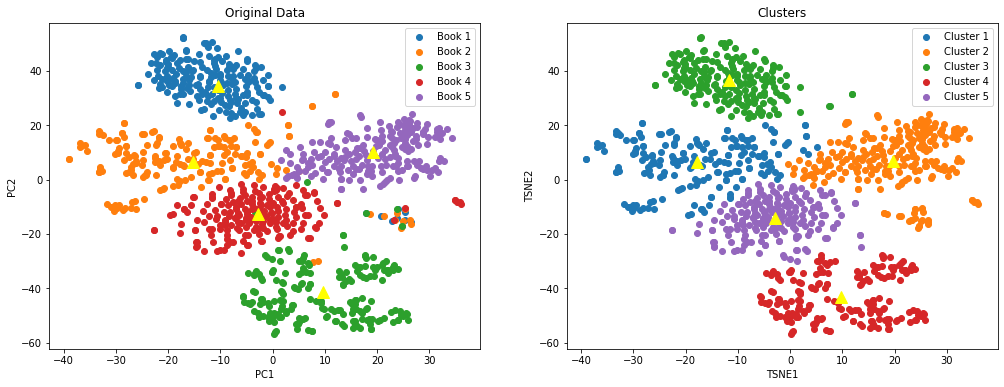

In [101]:
plot_clusters_tsne(bow_model, agg_bow_model, y)

In [102]:
calc_scores(bow_model, agg_bow_model, y)

Silhouette Coefficient is: 0.0229
Cohen’s kappa Score is: -0.2463


#### TF-IDF

In [103]:
tfidf_model, tfidf_vectorizer = tfidf_transform(books_df.Paragraphs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


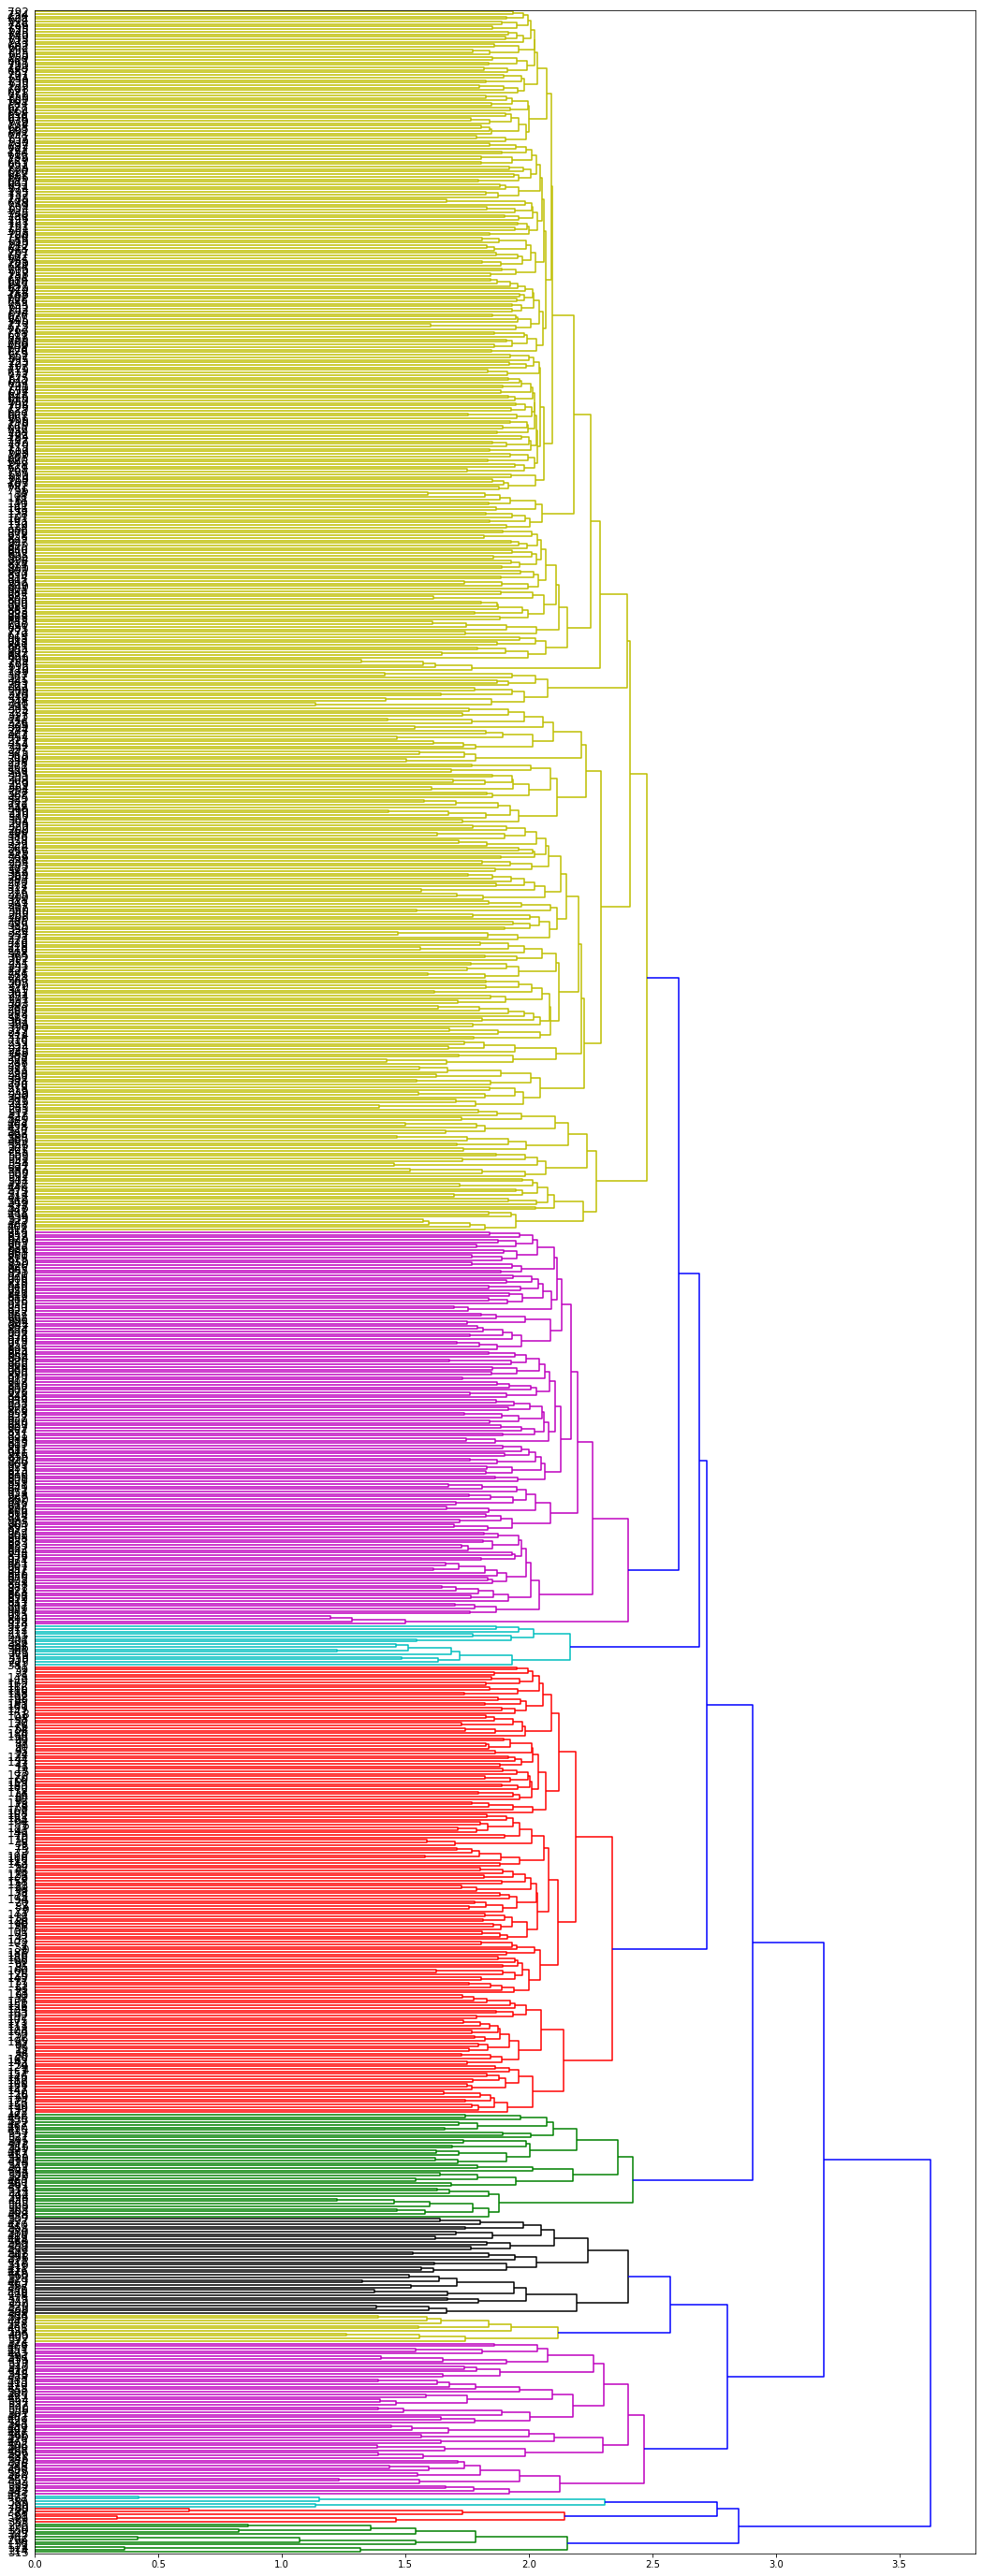

In [104]:
draw_dendo(dist_matrix(tfidf_model))

In [105]:
agg_tfidf_model = AgglomerativeClustering(n_clusters=5).fit(tfidf_model.toarray(), y)
agg_tfidf_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

[[  0 399]
 [  1 183]
 [  2 191]
 [  3 204]
 [  4  23]]


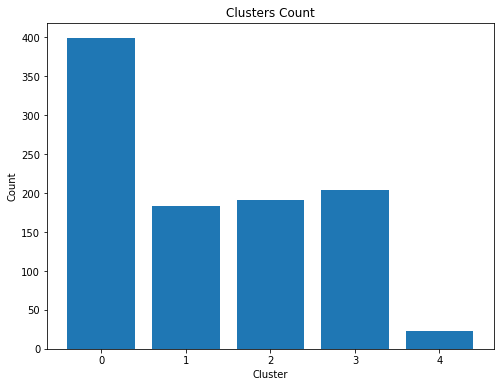

In [106]:
cluster_count(agg_tfidf_model)

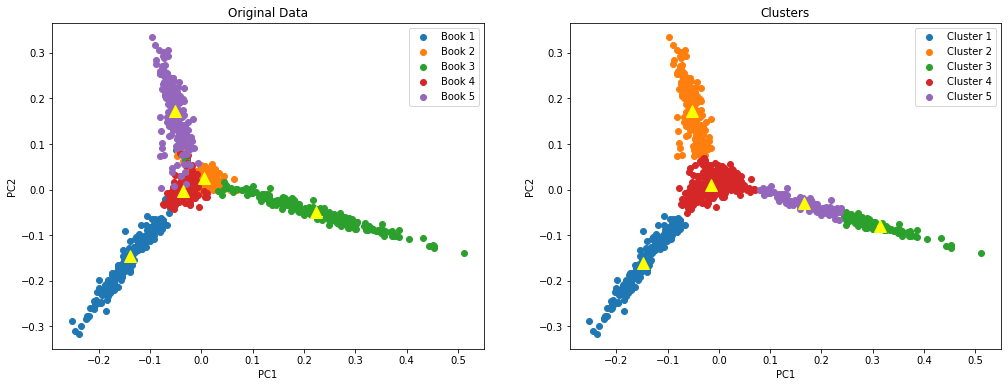

In [107]:
plot_clusters(tfidf_model, agg_tfidf_model, y)

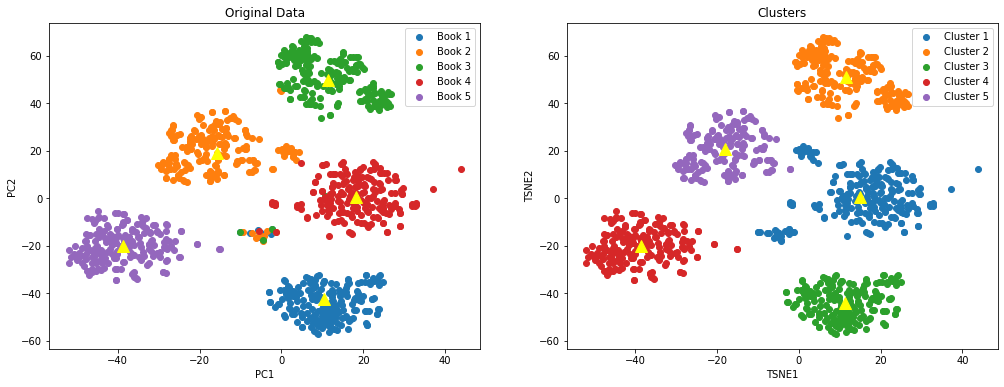

In [108]:
plot_clusters_tsne(tfidf_model, agg_tfidf_model, y) 

In [109]:
calc_scores(tfidf_model, agg_tfidf_model, y)

Silhouette Coefficient is: 0.0247
Cohen’s kappa Score is: -0.2425


###### Try Train Test Split

In [110]:
X = books_df.Paragraphs
y = books_df.label_num

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [112]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
bow_train = vectorizer.fit_transform(X_train)


In [113]:
tr_tfidf_model, tr_tfidf_vectorizer = tfidf_transform(X_train)

In [114]:
tr_tfidf_model

<800x17555 sparse matrix of type '<class 'numpy.float64'>'
	with 91858 stored elements in Compressed Sparse Row format>

In [115]:
tr_tfidf_vectorizer.transform(X_test)

<200x17555 sparse matrix of type '<class 'numpy.float64'>'
	with 20766 stored elements in Compressed Sparse Row format>

In [116]:
tt_agg_tfidf_model = AgglomerativeClustering(n_clusters=5).fit(tr_tfidf_model.toarray(), y_train)
tt_agg_tfidf_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

In [117]:
tt_agg_tfidf_model.fit_predict(tr_tfidf_vectorizer.transform(X_test).toarray())

array([0, 4, 4, 4, 4, 4, 4, 0, 2, 3, 2, 3, 4, 2, 2, 2, 1, 2, 4, 1, 0, 3,
       1, 0, 1, 1, 3, 2, 2, 2, 1, 3, 4, 0, 1, 3, 4, 0, 2, 3, 1, 3, 1, 2,
       0, 1, 2, 4, 0, 2, 0, 2, 0, 0, 3, 3, 4, 3, 1, 2, 4, 3, 0, 1, 4, 4,
       4, 2, 3, 0, 3, 0, 0, 4, 1, 1, 4, 3, 0, 1, 4, 3, 1, 4, 1, 0, 2, 4,
       4, 1, 1, 0, 0, 1, 4, 0, 4, 3, 3, 2, 4, 1, 2, 1, 4, 4, 0, 2, 3, 2,
       0, 2, 2, 2, 3, 0, 3, 2, 0, 1, 2, 0, 4, 1, 1, 0, 0, 0, 2, 2, 0, 2,
       1, 2, 0, 3, 3, 1, 3, 3, 3, 1, 4, 1, 2, 2, 2, 1, 2, 1, 4, 3, 2, 0,
       2, 0, 1, 4, 3, 2, 0, 4, 4, 4, 2, 4, 1, 4, 1, 1, 1, 0, 3, 2, 4, 1,
       1, 1, 2, 4, 0, 4, 1, 0, 2, 3, 4, 1, 2, 4, 2, 2, 4, 3, 1, 0, 1, 1,
       4, 3])

In [118]:
y_test.to_numpy()

array([2, 3, 3, 3, 2, 3, 3, 2, 4, 0, 4, 0, 3, 4, 4, 4, 1, 4, 3, 1, 2, 0,
       1, 2, 1, 1, 0, 4, 4, 4, 1, 0, 3, 2, 1, 0, 3, 2, 4, 0, 1, 0, 1, 4,
       1, 1, 4, 3, 2, 4, 2, 4, 1, 2, 0, 0, 3, 0, 1, 4, 1, 0, 2, 1, 3, 3,
       3, 4, 0, 2, 0, 2, 2, 3, 1, 1, 3, 0, 2, 1, 3, 0, 1, 0, 1, 2, 4, 3,
       3, 1, 1, 2, 2, 1, 3, 2, 3, 0, 0, 4, 3, 1, 4, 1, 3, 3, 2, 4, 0, 4,
       2, 4, 4, 4, 0, 2, 0, 4, 2, 1, 4, 2, 3, 1, 1, 2, 2, 2, 4, 4, 2, 4,
       1, 4, 2, 0, 0, 1, 0, 0, 0, 1, 3, 1, 4, 4, 4, 1, 4, 1, 3, 0, 4, 2,
       4, 2, 1, 3, 0, 4, 2, 3, 3, 3, 4, 3, 1, 3, 1, 1, 1, 2, 0, 4, 2, 1,
       1, 1, 4, 3, 2, 3, 1, 2, 4, 0, 1, 1, 4, 3, 4, 4, 3, 0, 1, 2, 1, 1,
       3, 0])

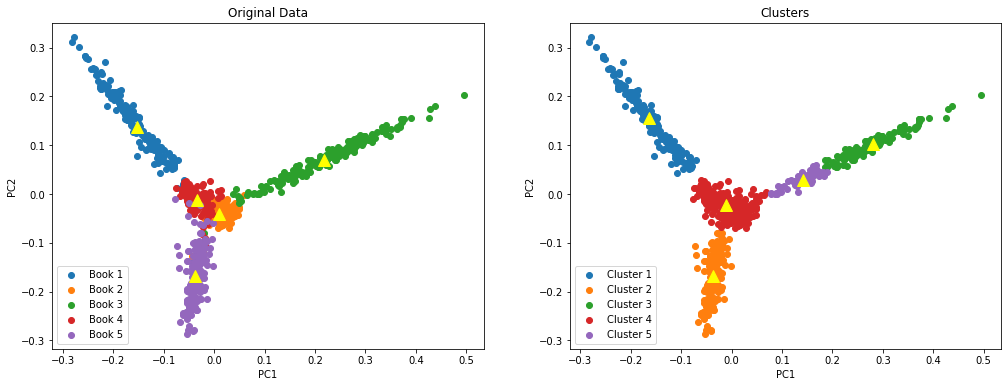

In [119]:
plot_clusters(tr_tfidf_model, tt_agg_tfidf_model, y_train)

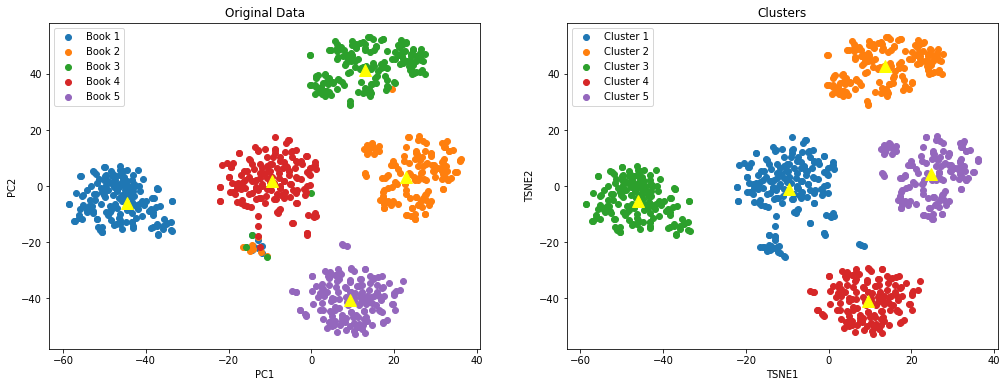

In [120]:
plot_clusters_tsne(tr_tfidf_model, tt_agg_tfidf_model, y_train) 

In [121]:
calc_scores(tr_tfidf_model, tt_agg_tfidf_model, y_train)

Silhouette Coefficient is: 0.0255
Cohen’s kappa Score is: -0.2523


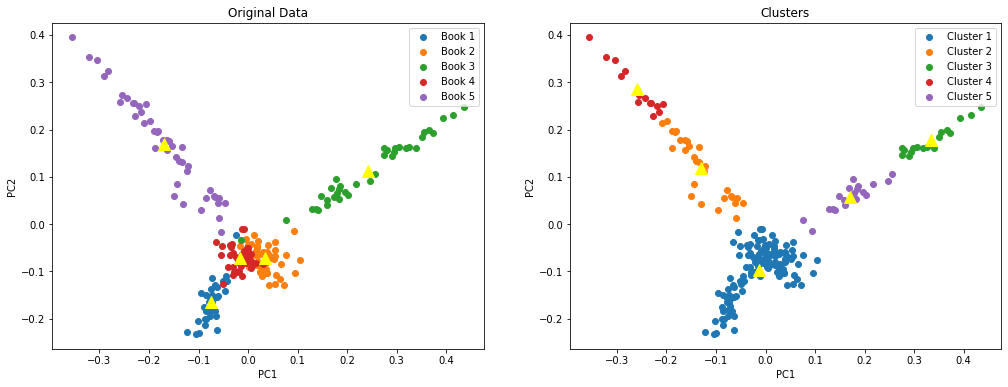

In [122]:
plot_clusters(tr_tfidf_vectorizer.transform(X_test), tt_agg_tfidf_model, y_test)

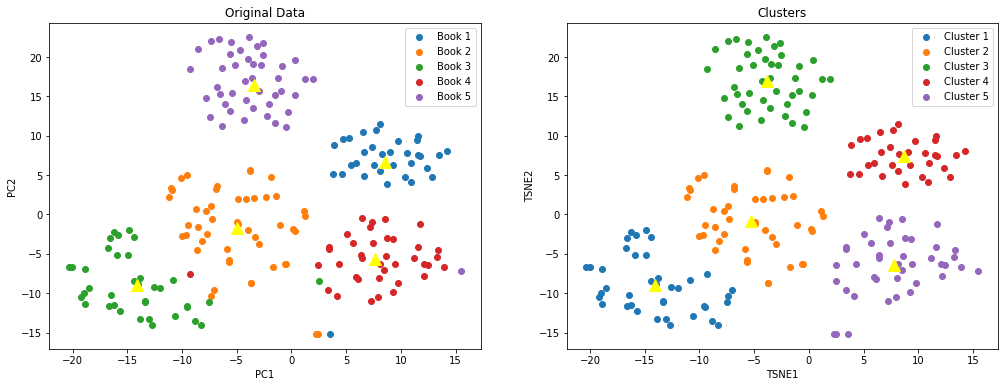

In [123]:
plot_clusters_tsne(tr_tfidf_vectorizer.transform(X_test), tt_agg_tfidf_model, y_test) 

In [124]:
calc_scores(tr_tfidf_vectorizer.transform(X_test), tt_agg_tfidf_model, y_test)

Silhouette Coefficient is: 0.0255
Cohen’s kappa Score is: 0.0229


---

#### LDA

LDA + BoW

In [125]:
lda_bow_model, lda_vectorizer = lda_transform(bow_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


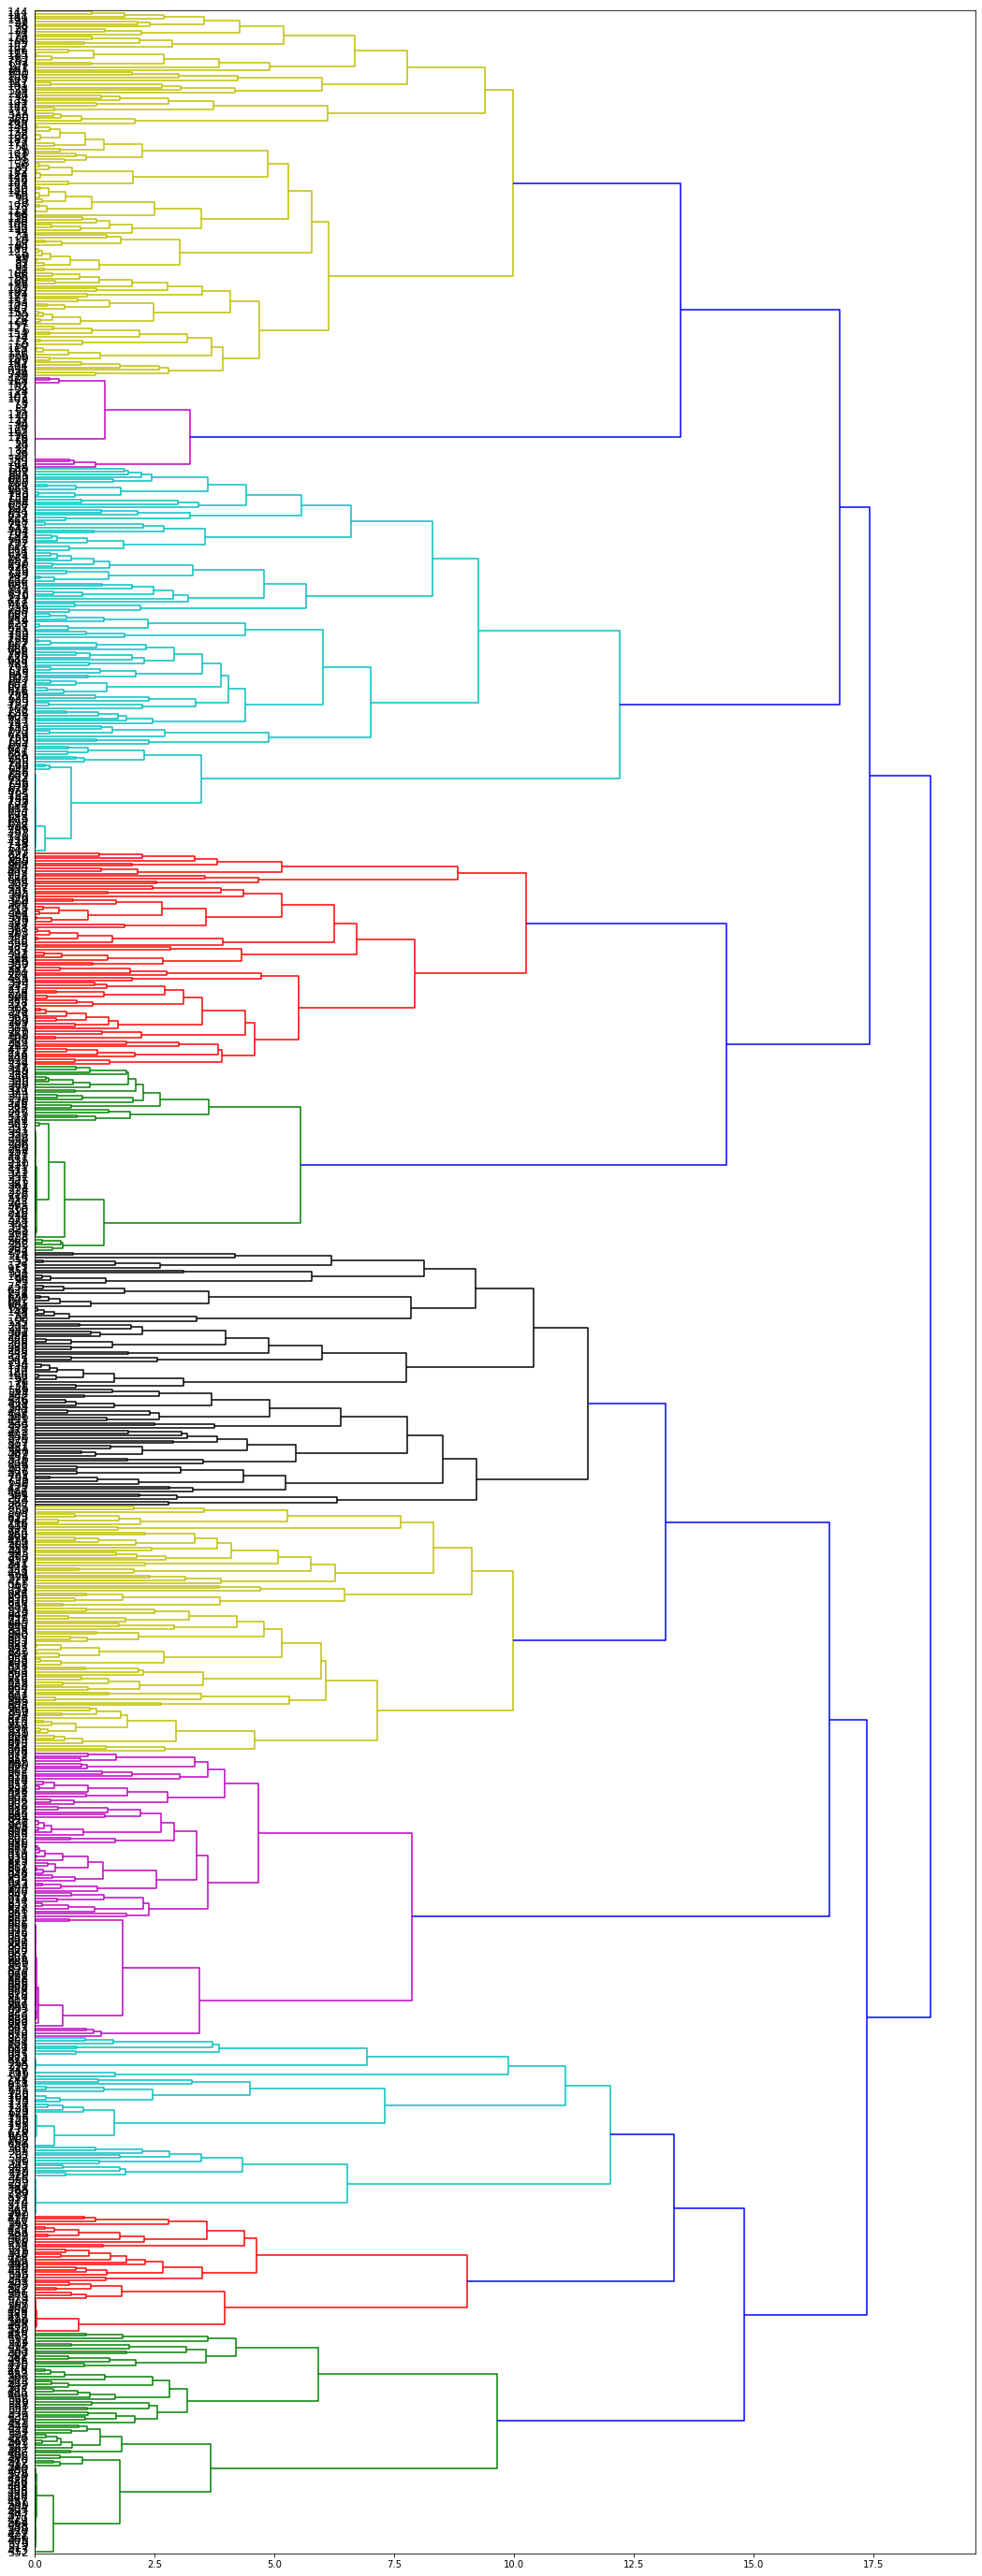

In [126]:
draw_dendo(dist_matrix(lda_bow_model))

In [127]:
agg_lda_bow_model = AgglomerativeClustering(n_clusters=5).fit(lda_bow_model.toarray(), y)
agg_lda_bow_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

[[  0 298]
 [  1 171]
 [  2 150]
 [  3 194]
 [  4 187]]


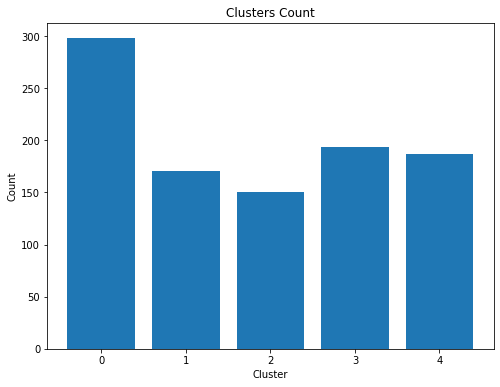

In [128]:
cluster_count(agg_lda_bow_model)

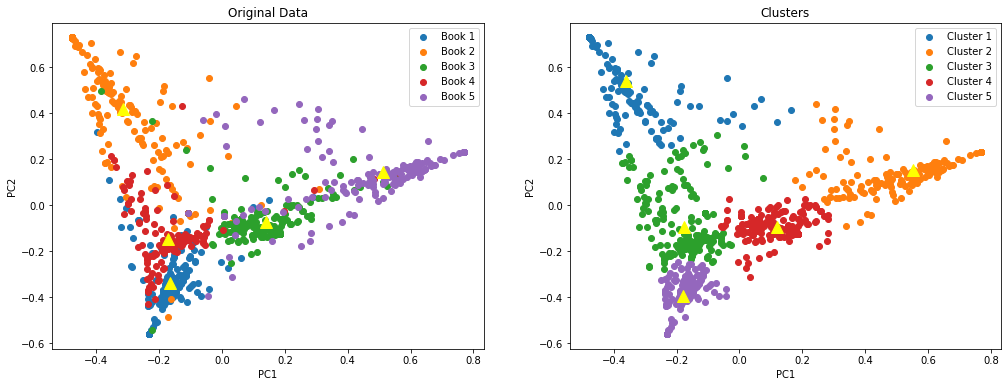

In [129]:
plot_clusters(lda_bow_model, agg_lda_bow_model, y)

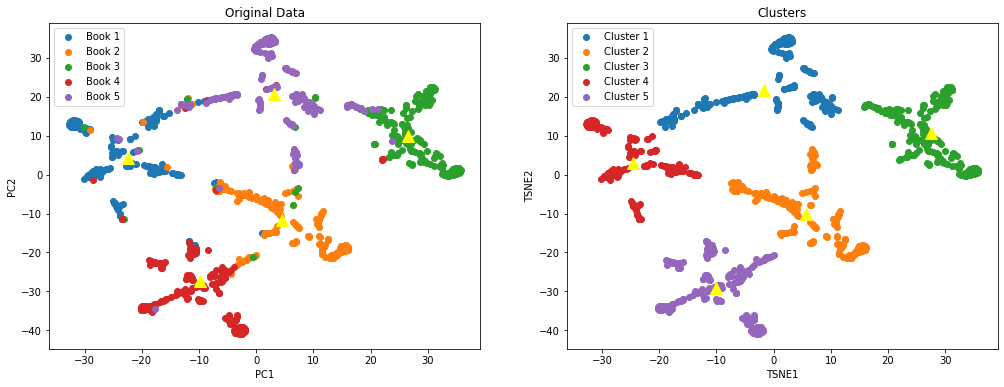

In [130]:
plot_clusters_tsne(lda_bow_model, agg_lda_bow_model, y) 

In [131]:
calc_scores(lda_bow_model, agg_lda_bow_model, y)

Silhouette Coefficient is: 0.3836
Cohen’s kappa Score is: -0.2112


LDA + TF-IDF

In [132]:
lda_tfidf_model, lda_tfidf_vectorizer = lda_transform(tfidf_model)

In [133]:
len(lda_tfidf_vectorizer.components_[1])

19544

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


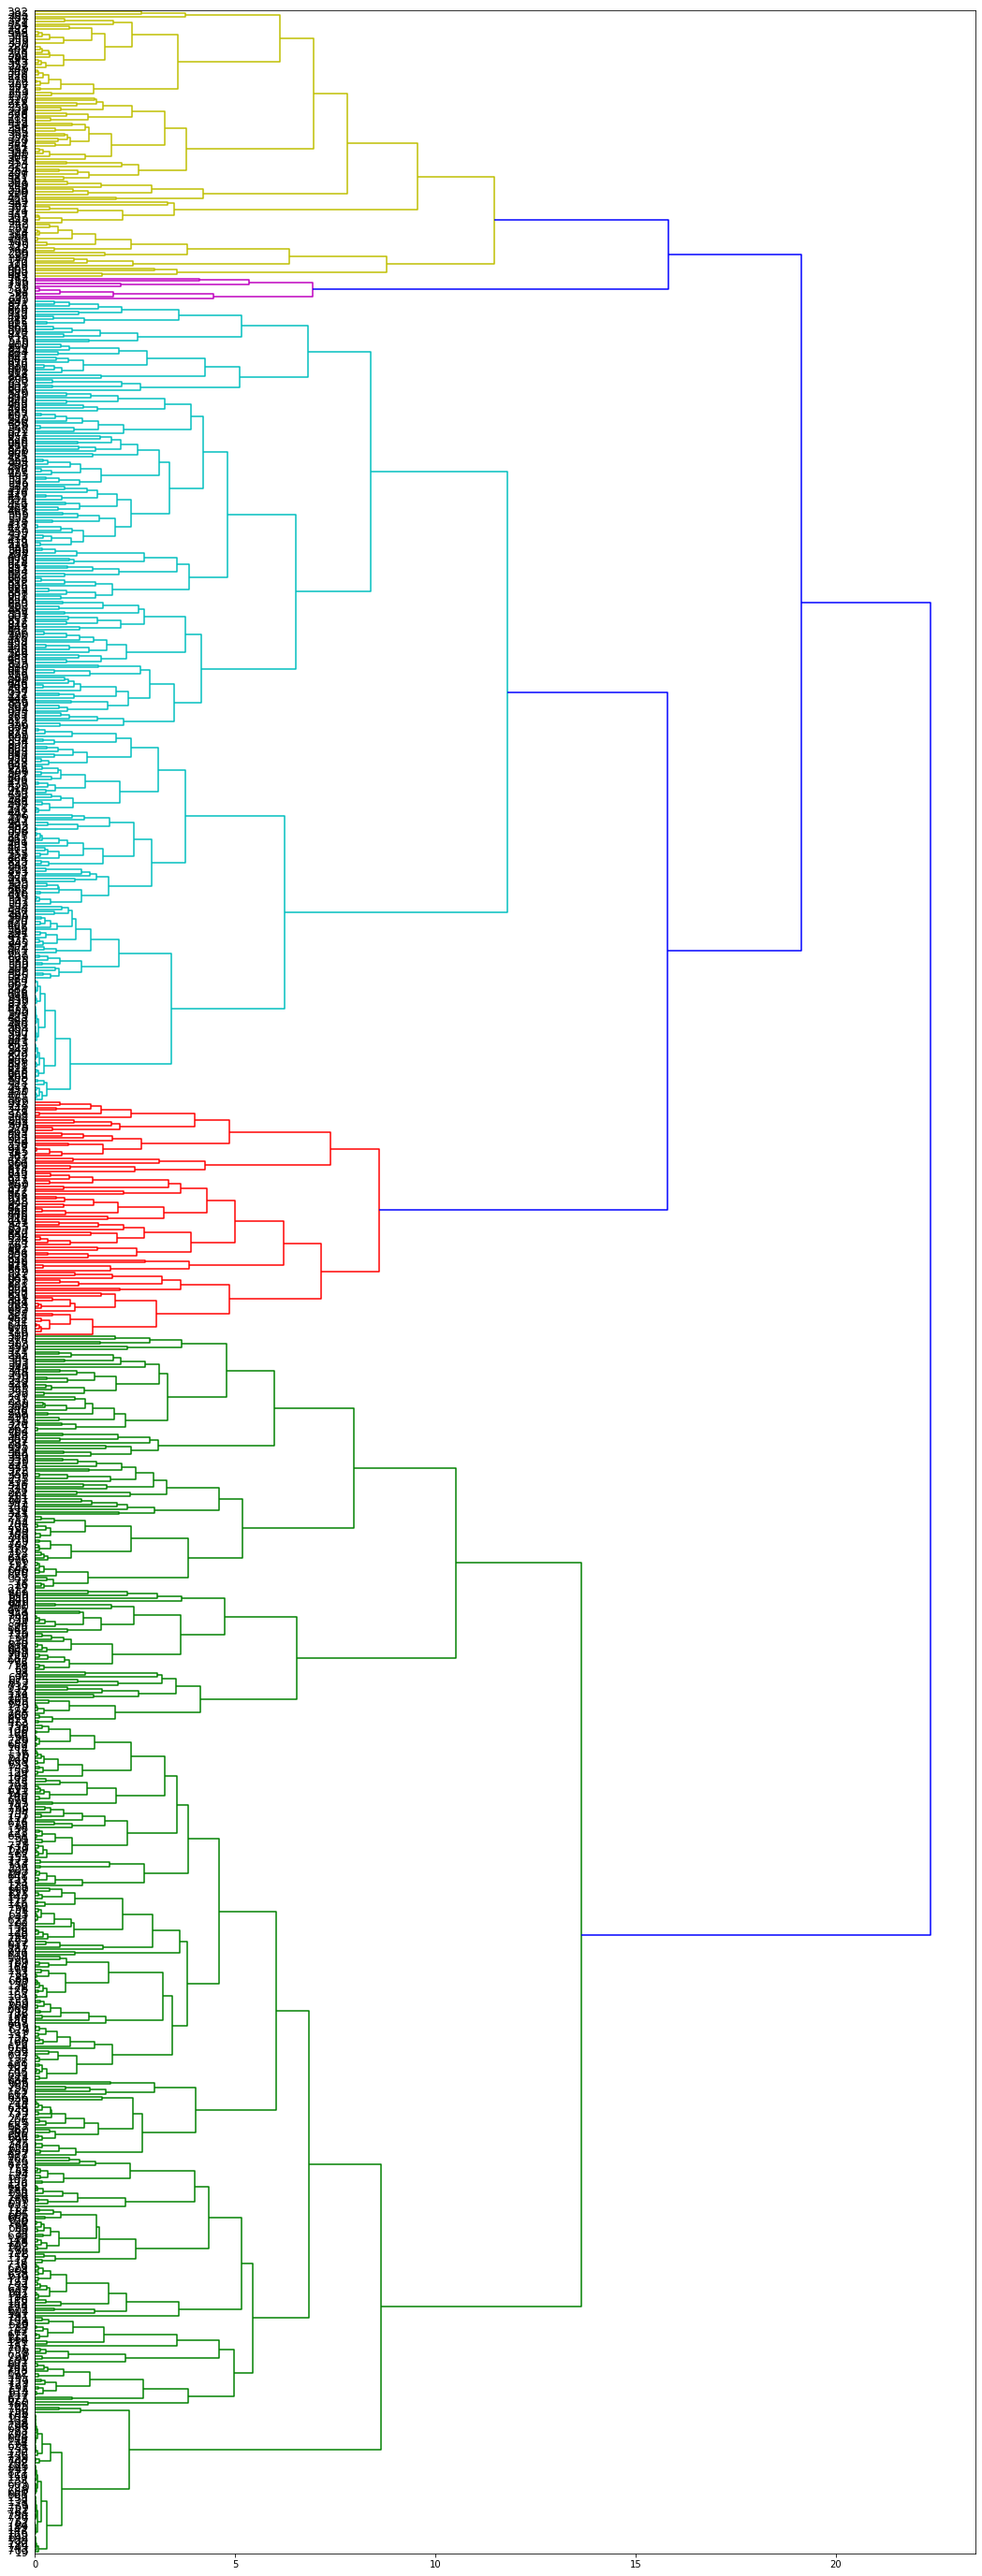

In [134]:
draw_dendo(dist_matrix(lda_tfidf_model))

In [135]:
agg_lda_tfidf_model = AgglomerativeClustering(n_clusters=5).fit(lda_tfidf_model.toarray(), y)
agg_lda_tfidf_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

[[  0 439]
 [  1 144]
 [  2 302]
 [  3  24]
 [  4  91]]


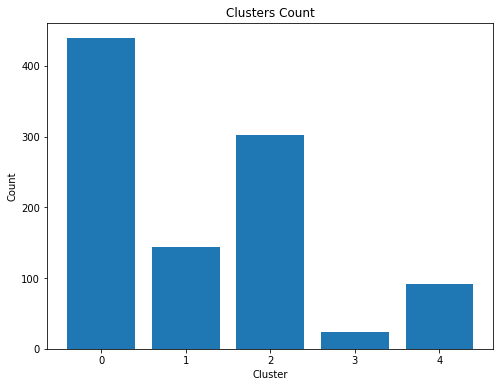

In [136]:
cluster_count(agg_lda_tfidf_model)

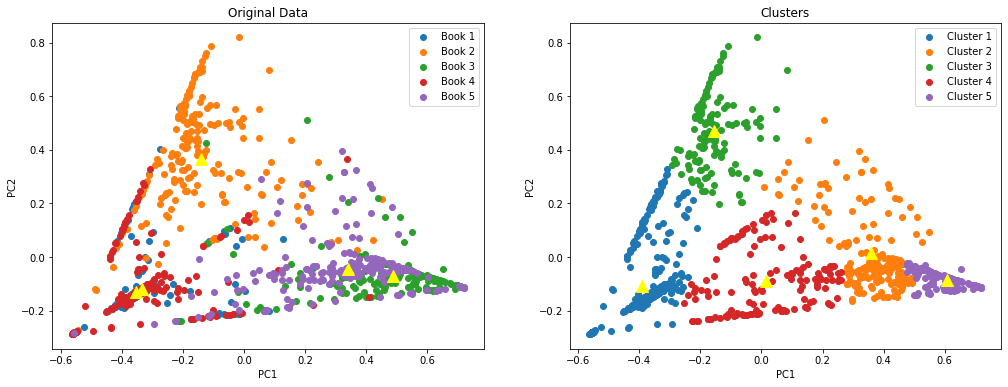

In [137]:
plot_clusters(lda_tfidf_model, agg_lda_tfidf_model, y)

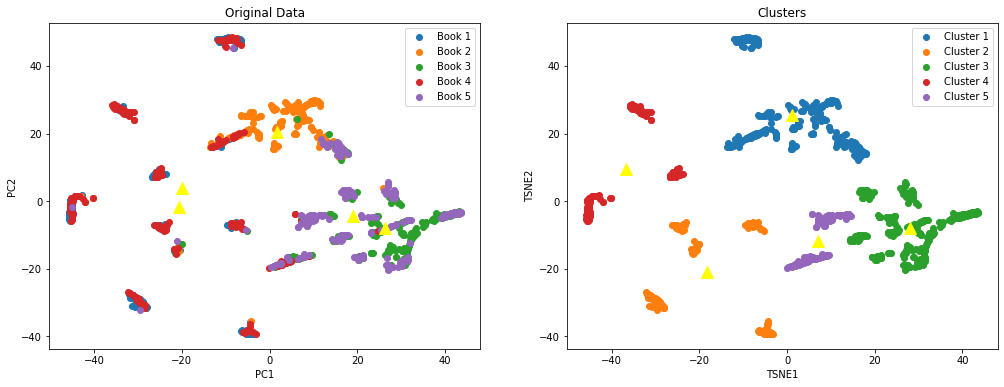

In [138]:
plot_clusters_tsne(lda_tfidf_model, agg_lda_tfidf_model, y) 

In [139]:
calc_scores(lda_tfidf_model, agg_lda_tfidf_model, y)

Silhouette Coefficient is: 0.2928
Cohen’s kappa Score is: 0.35


---

#### Word Embedding

In [145]:
d2v = d2v_transform(books_df.Paragraphs)

In [146]:
d2v_sparse = sparse.csr_matrix(d2v)

In [147]:
d2v_sparse

<1000x50 sparse matrix of type '<class 'numpy.float32'>'
	with 50000 stored elements in Compressed Sparse Row format>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


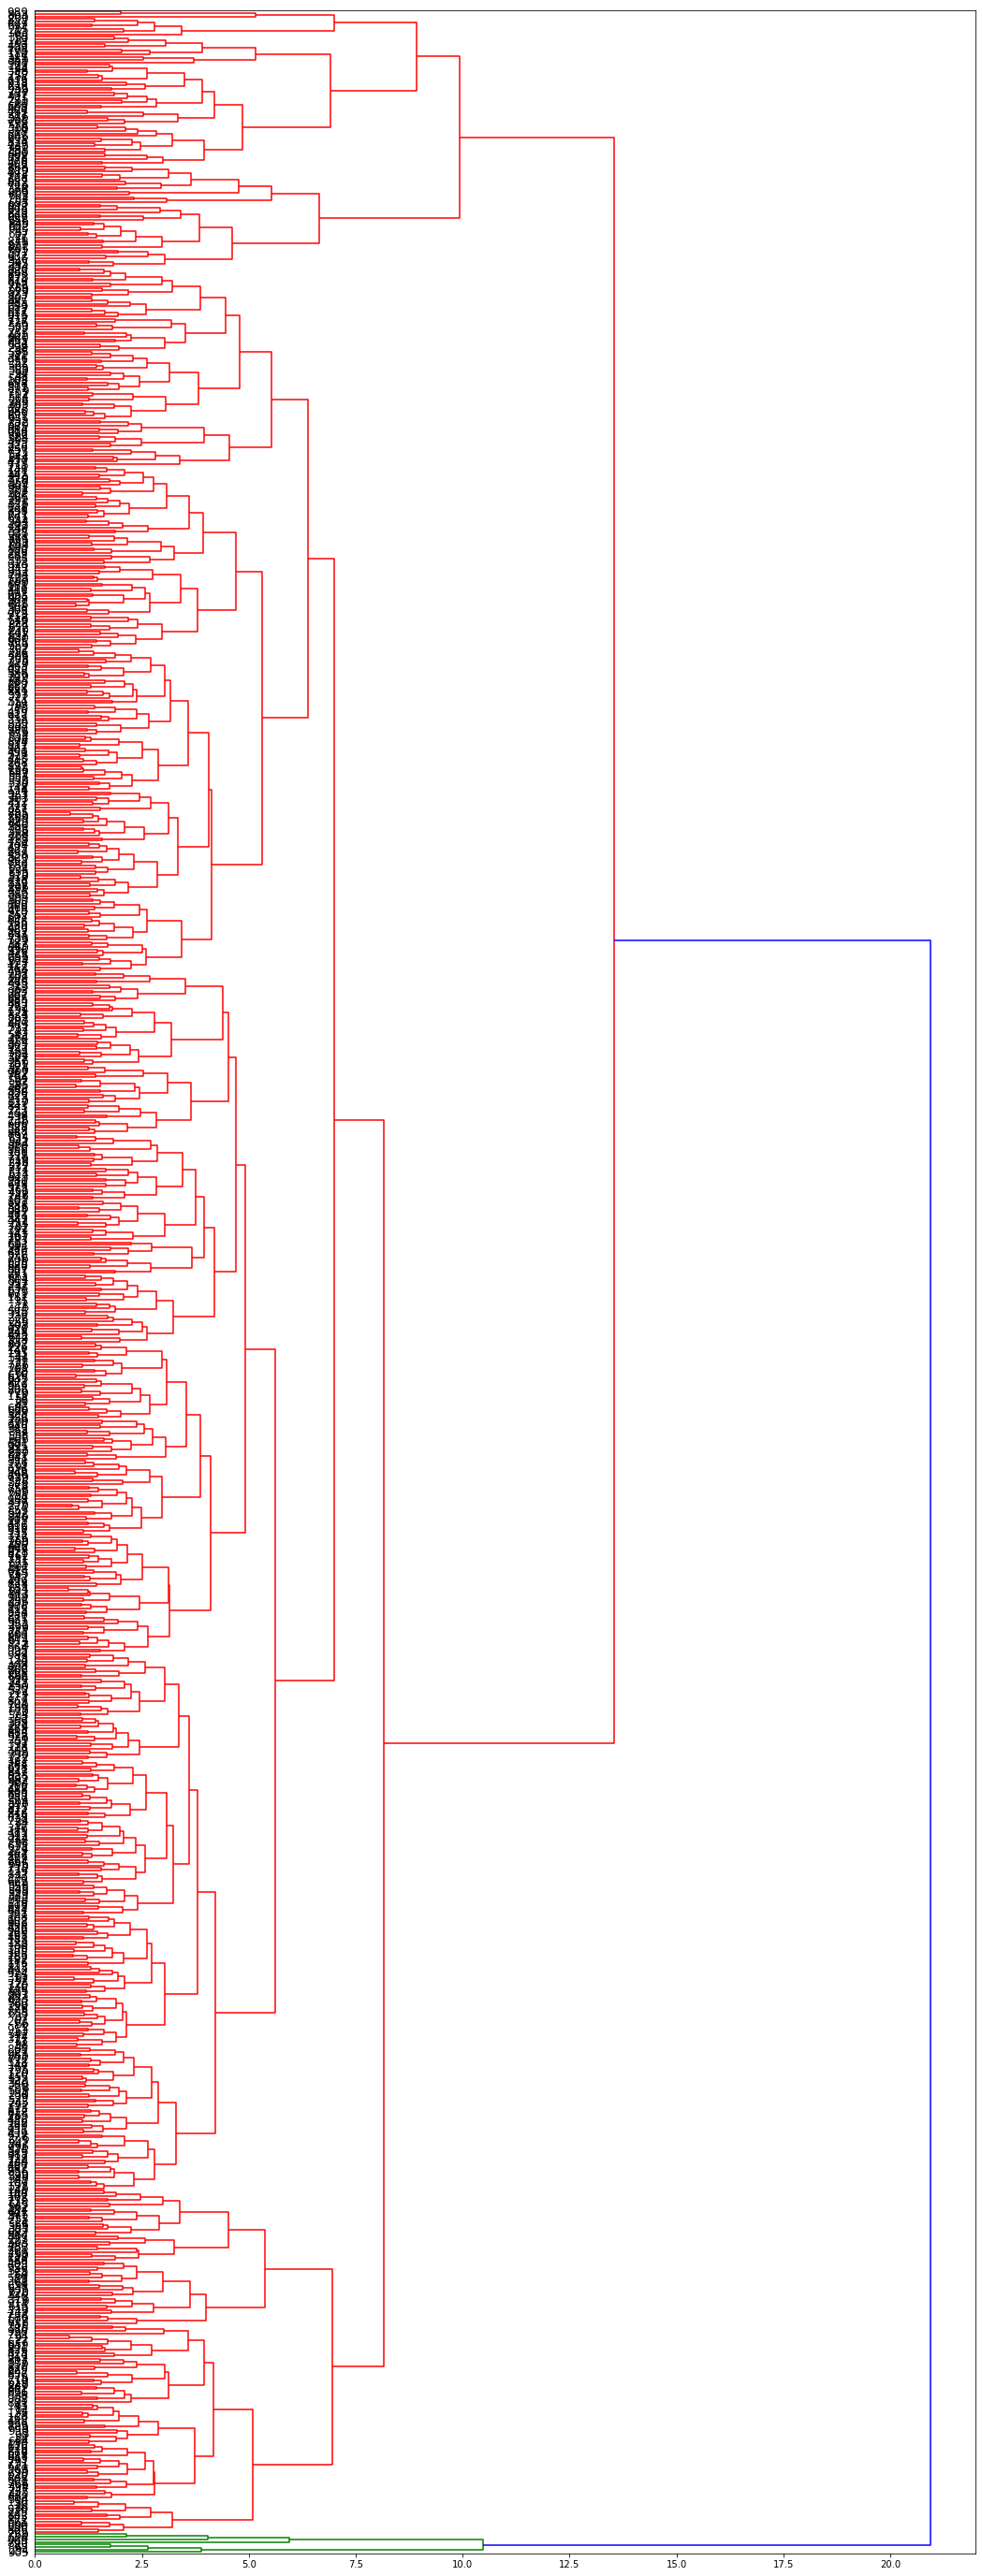

In [148]:
draw_dendo(dist_matrix(d2v_sparse))

In [149]:
agg_doc2vec_model = AgglomerativeClustering(n_clusters=5).fit(d2v_sparse.toarray(), y)
agg_doc2vec_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

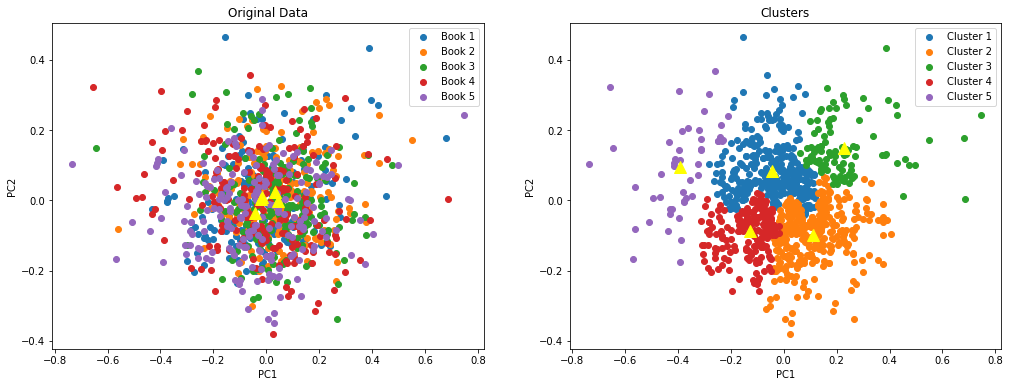

In [150]:
plot_clusters(d2v_sparse, agg_doc2vec_model, y)

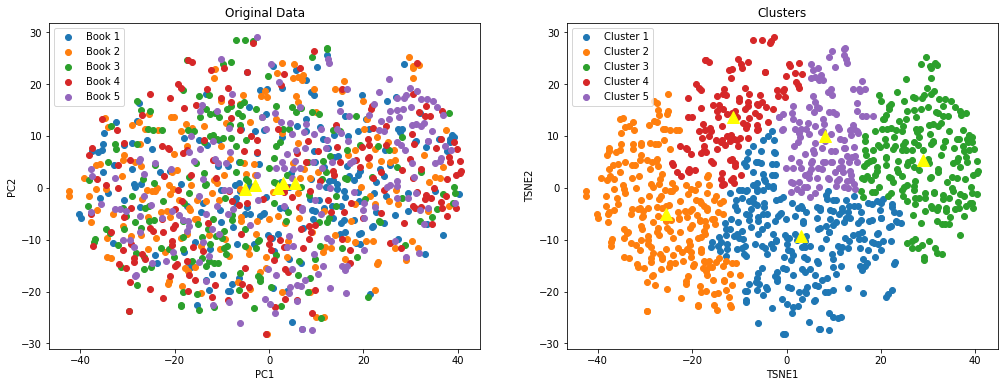

In [151]:
plot_clusters_tsne(d2v_sparse, agg_doc2vec_model, y) 

In [152]:
calc_scores(d2v_sparse, agg_doc2vec_model, y)

Silhouette Coefficient is: 0.0503
Cohen’s kappa Score is: -0.0175


### *Continue* **Error Analysis** steps

[[  0 298]
 [  1 171]
 [  2 150]
 [  3 194]
 [  4 187]]


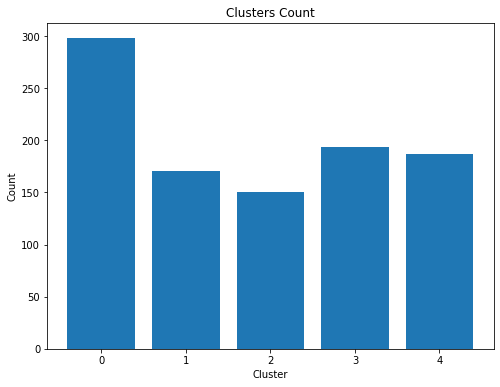

In [153]:
cluster_count(agg_lda_bow_model)

In [154]:
df_clusters = books_df.copy()

In [155]:
df_clusters['cluster_agg_bow'] = agg_bow_model.labels_
df_clusters['cluster_agg_tfidf'] = agg_tfidf_model.labels_
df_clusters['cluster_agg_lda_bow'] = agg_lda_bow_model.labels_ 
df_clusters['cluster_agg_lda_tfidf'] = agg_lda_tfidf_model.labels_
df_clusters['cluster_agg_doc2vec'] = agg_doc2vec_model.labels_

In [156]:
df_clusters.Label[df_clusters.cluster_agg_bow == 1].value_counts()

c    189
b      2
Name: Label, dtype: int64

In [157]:
df_clusters.Label.groupby(df_clusters.cluster_agg_bow).count()

cluster_agg_bow
0    399
1    191
2    191
3    199
4     20
Name: Label, dtype: int64

In [158]:
df_clusters[['Label','cluster_agg_bow']].groupby(df_clusters.cluster_agg_bow).count()

Label  cluster_agg_bow
cluster_agg_bow                        
0                  399              399
1                  191              191
2                  191              191
3                  199              199
4                   20               20

In [159]:
df_clusters.groupby(['cluster_agg_bow', 'Label']).size()

cluster_agg_bow  Label
0                a          1
                 b        190
                 c          9
                 d        198
                 e          1
1                b          2
                 c        189
2                a        191
3                e        199
4                a          8
                 b          8
                 c          2
                 d          2
dtype: int64

In [160]:
pd.crosstab(df_clusters.cluster_agg_bow, df_clusters.Label)

Label              a    b    c    d    e
cluster_agg_bow                         
0                  1  190    9  198    1
1                  0    2  189    0    0
2                191    0    0    0    0
3                  0    0    0    0  199
4                  8    8    2    2    0

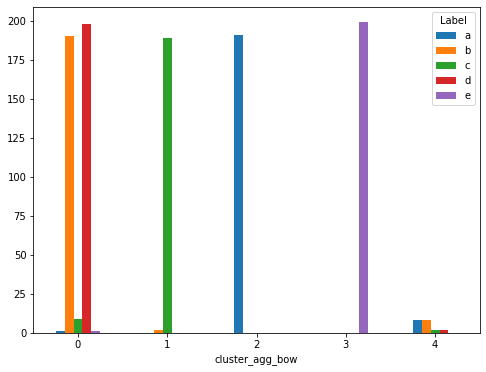

In [161]:
pd.crosstab(df_clusters.cluster_agg_bow, df_clusters.Label).plot.bar(figsize=(8,6), rot=0);

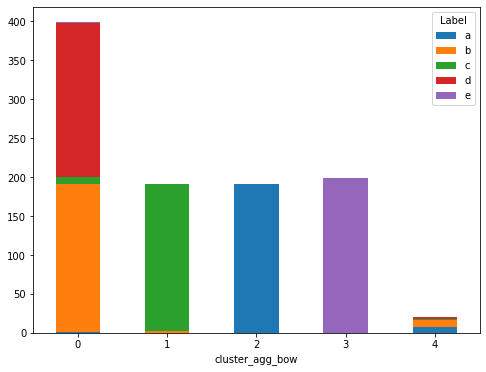

In [162]:
pd.crosstab(df_clusters.cluster_agg_bow, df_clusters.Label).plot.bar(figsize=(8,6), stacked=True, rot=0);

Label              a    b    c    d    e
cluster_agg_bow                         
0                  1  190    9  198    1
1                  0    2  189    0    0
2                191    0    0    0    0
3                  0    0    0    0  199
4                  8    8    2    2    0


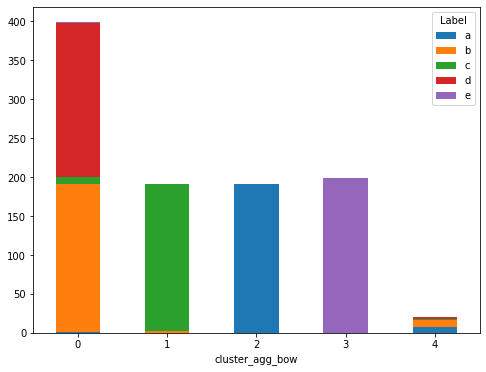

In [163]:
print(pd.crosstab(df_clusters.cluster_agg_bow, df_clusters.Label))
pd.crosstab(df_clusters.cluster_agg_bow, df_clusters.Label).plot.bar(figsize=(8,6), stacked=True, rot=0);

In [164]:
df_clusters.groupby(['cluster_agg_bow', 'Label']).size()

cluster_agg_bow  Label
0                a          1
                 b        190
                 c          9
                 d        198
                 e          1
1                b          2
                 c        189
2                a        191
3                e        199
4                a          8
                 b          8
                 c          2
                 d          2
dtype: int64

In [165]:
for cluster_num in range(5):
  print("Cluster", cluster_num)
  print(df_clusters.Label[df_clusters.cluster_agg_bow == cluster_num].value_counts())
  print("------------------------------------------------------------------------", "\n")

Cluster 0
d    198
b    190
c      9
a      1
e      1
Name: Label, dtype: int64
------------------------------------------------------------------------ 

Cluster 1
c    189
b      2
Name: Label, dtype: int64
------------------------------------------------------------------------ 

Cluster 2
a    191
Name: Label, dtype: int64
------------------------------------------------------------------------ 

Cluster 3
e    199
Name: Label, dtype: int64
------------------------------------------------------------------------ 

Cluster 4
a    8
b    8
c    2
d    2
Name: Label, dtype: int64
------------------------------------------------------------------------ 



In [166]:
cols_df_names_labels = ['cluster_agg_bow', 'cluster_agg_tfidf', 'cluster_agg_lda_bow', 'cluster_agg_lda_tfidf', 'cluster_agg_doc2vec']

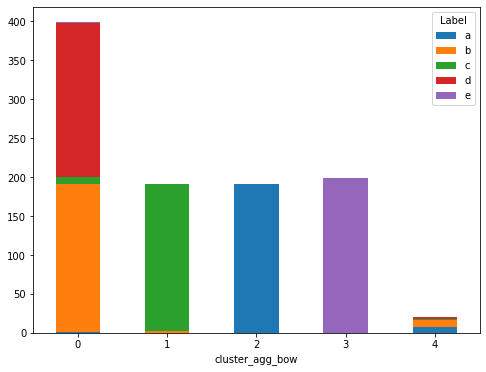

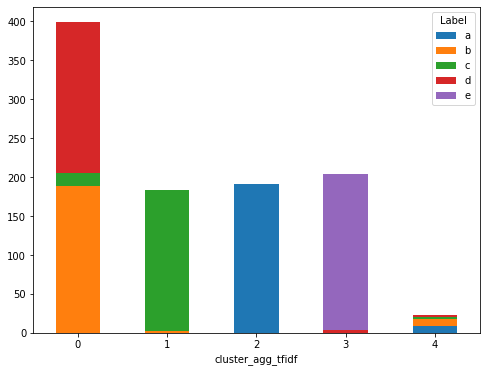

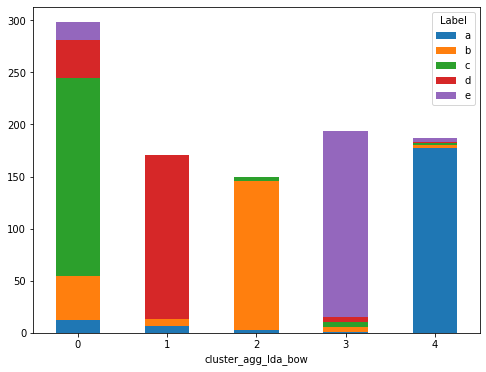

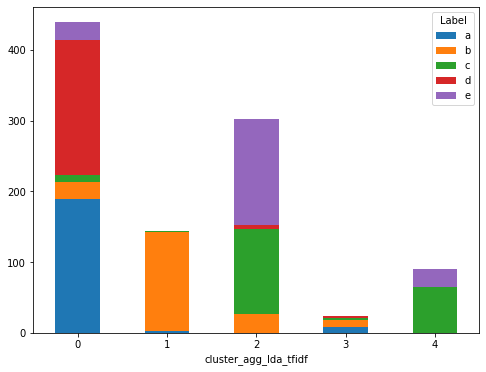

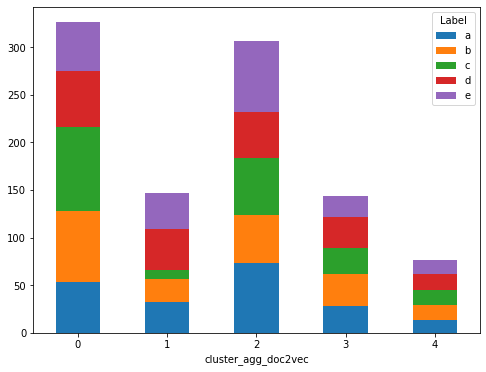

In [167]:
for col_name in cols_df_names_labels:
  pd.crosstab(df_clusters[col_name], df_clusters.Label).plot.bar(figsize=(8,6), stacked=True, rot=0);

#### Explore Book1

In [168]:
books_df[books_df.Label == 'a'].head()

Paragraphs Label  Index  label_num
0  pounded head tiny troop second time life hed h...     a      1          0
1  trailed unloading belt dumped bales skins ingo...     a      2          0
2  long later badly battered blackened scuffed ol...     a      3          0
3  derec fairly wept dont see asked derec pleadin...     a      4          0
4  getting two horses patch woodland yondershe po...     a      5          0

In [169]:
book1_d2v = sparse.csr_matrix(d2v_transform(books_df.Paragraphs[books_df.Label == 'a']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


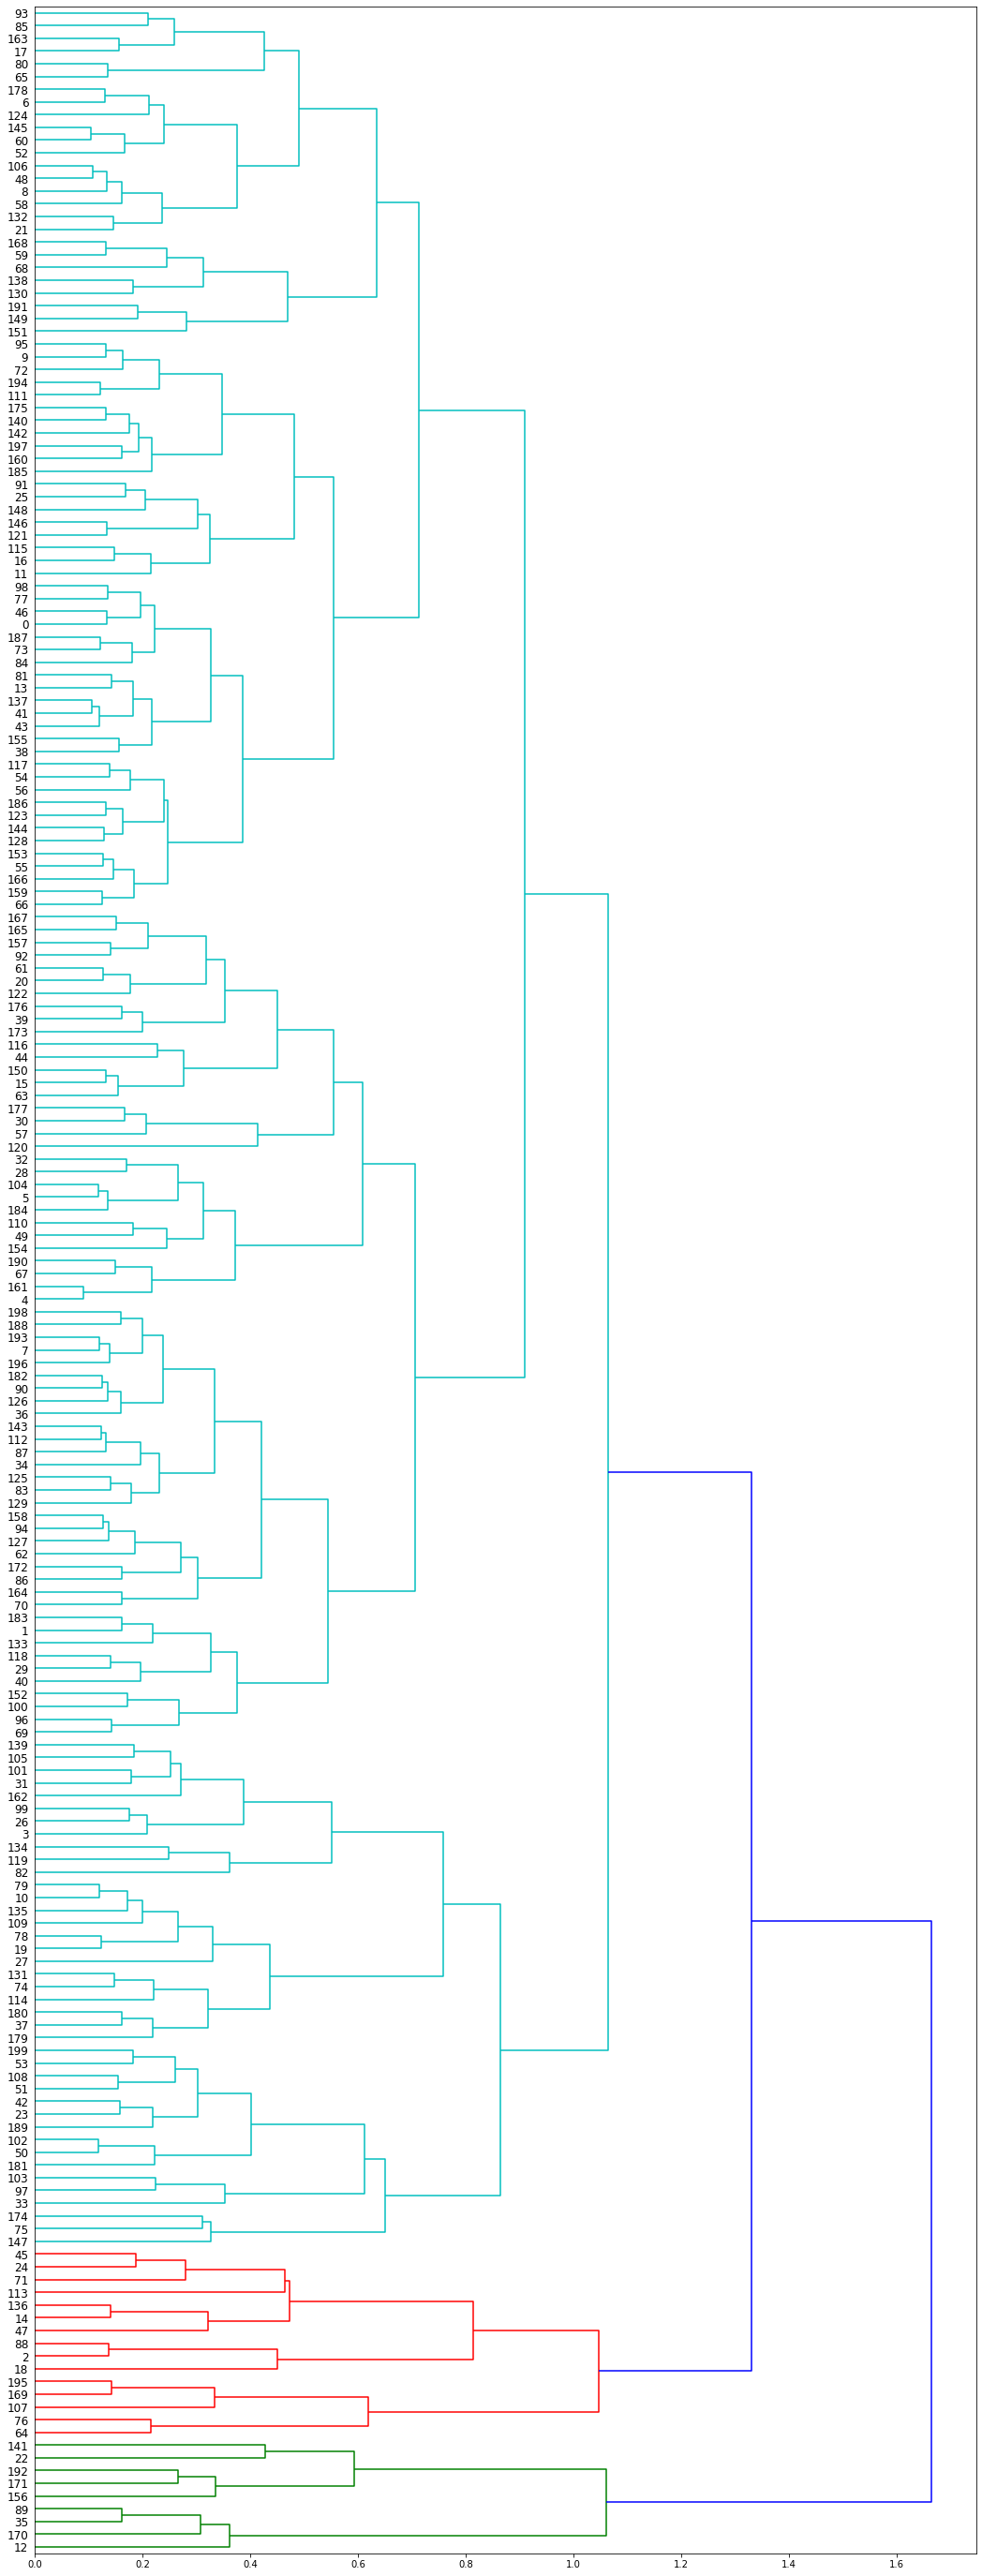

In [170]:
draw_dendo(dist_matrix(book1_d2v))


In [171]:
books_df.Paragraphs[136]

'ravenous seemed lay awake aeons must dozed awakened yell complete yell first part one stopped particularly unpleasant fashion echoes went reverberating stony walls castle hoddan bed stunpistol hand hurry first yell followed shouts outcries clashing steel upon steel frenzied tumult combat dark uproar moved seconds sound fighting came plainly different direction striking force sort went rushing indifferently defended corridors would pass hoddans door growled feudal world presumably one might expect anything situation etiquette required rejected suitor carry certain scornful maiden force young lordling named ghek carry fani considered man spirit gun went somewhere powder gun exploding violently send metal bullet somewhere went instant almost silence intolerable screeching triumph shrieks another sort entirely excessively loud clash arms hoddan clothed nowat least clothed enough places stick stunpistols jerked door open irritably demanding would know side matter side fight door locked rag

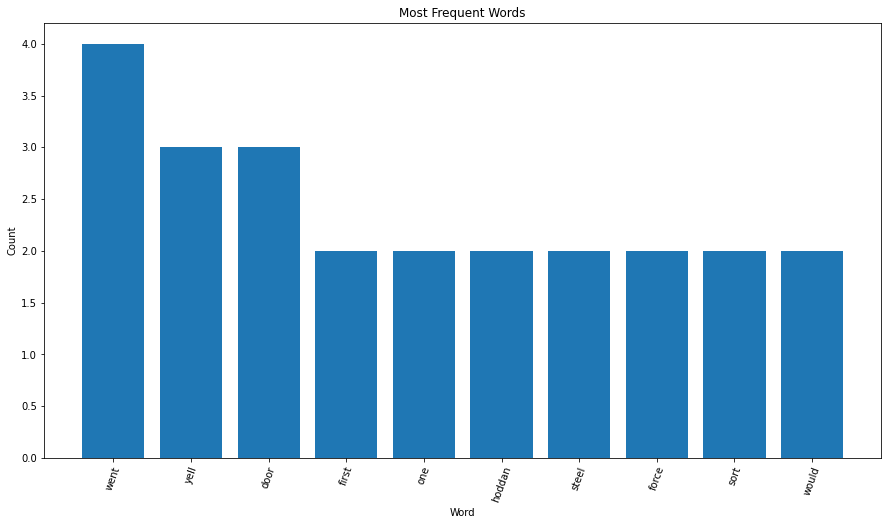

In [172]:
plot_word_bar_one_paragraph(books_df.Paragraphs[136])

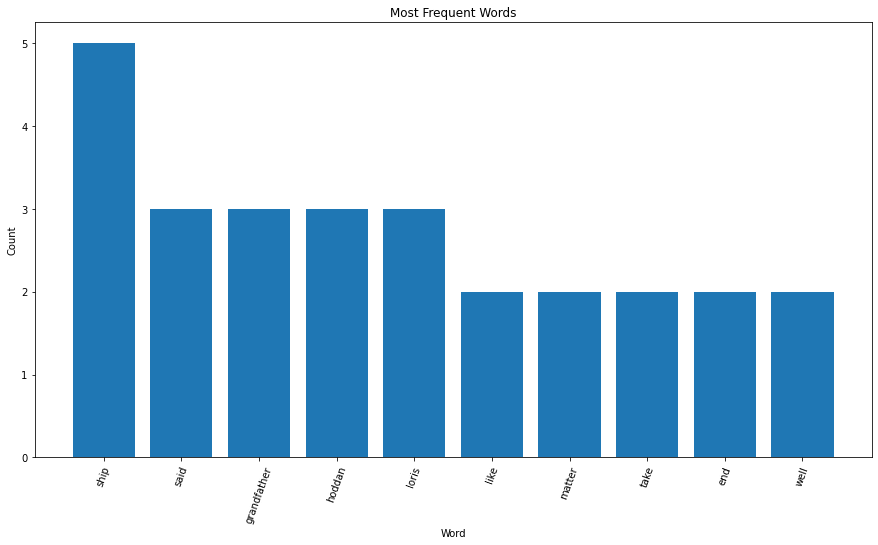

In [173]:
plot_word_bar_one_paragraph(books_df.Paragraphs[20])

In [174]:
books_df.Paragraphs[135]

'gave could grow fresh supplies without junglebreaking machinery junglebreaking machinery could imagine wanting anything less junglebreaking machinery hoddan raised head mechanics looked dully men maintenance asked repair things wear ships run materials need repairs long time tiredlooking man said slowly ship come trouble hydroponic garden keeps air fresh ocourse watercirculation pipes gone rusted havent got pipe fix keep water moving buckets hoddan got looked hadnt brought hydroponicgarden pipe supplies raw material took pair power snips cut away section cargo space walllining cut strips asked diameter pipe eyes made pipespirally wound around mandril linewelded solidity need ship said another man bearded man said heavily well make send ships need said hoddan well send tools make make tools must kinds repairs cant made machines ive brought well make tools make repairs picturetape machines reels show exactly illustration new idea mechanics immediate problems beside overall disaster flee

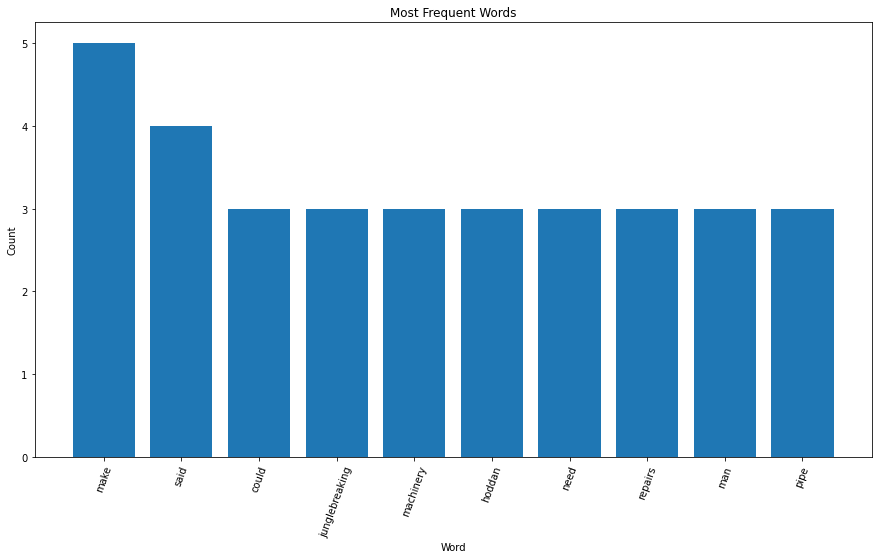

In [175]:
plot_word_bar_one_paragraph(books_df.Paragraphs[135])

In [176]:
books_df.Paragraphs[120]

'let go hoddan could tell liner pointed base toward planet force fields picked wabbled slightly free longer held solidly floated momentum hoddan nibbled fingernails nothing done forty minutes presently nothing done thirty twenty ten five three two liner barely twenty miles away hoddan fired rockets made colossal cloud vapor emptiness yacht stirred faintly shifted deftly lost suitable amount velocitywhich nearly straight planetand moved precision directness toward liner hoddan stirred controls swung whole small ship obviously could use spacedrive proper purpose switch cut certain elements lawlor unit cut others made modified driveunit ball lightning projector flaming speck pure incandescence sped yacht emptiness would miss hoddan swerved struck liners hull would momentarily paralyze every bit electric equipment ship would definitely go unnoticed calling liner said hoddan painfully microphone calling liner pirates attacking ship ten seconds get lifeboats hull settled back nibbling finger

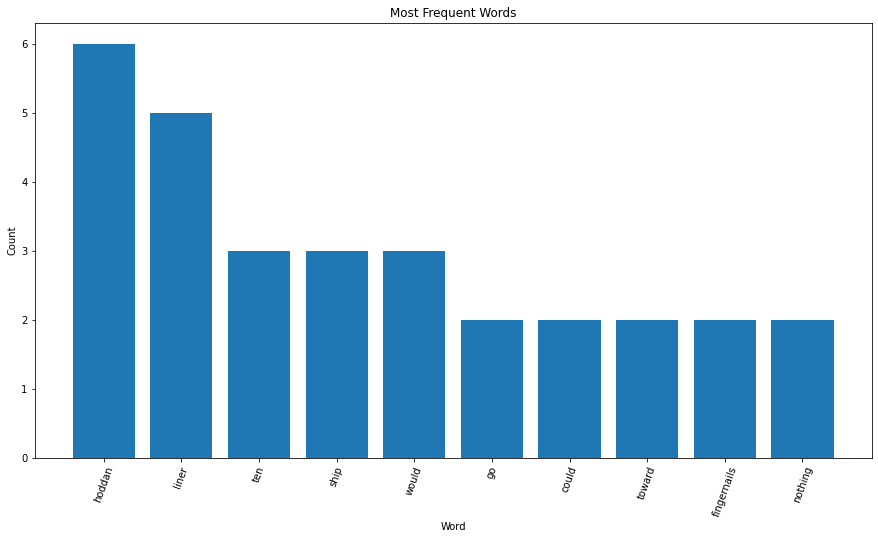

In [177]:
plot_word_bar_one_paragraph(books_df.Paragraphs[120])

word "men" repeated in both paragraphs 120 and 135 also "said" in 136 and 20

In [178]:
y[:200]

0      0
1      0
2      0
3      0
4      0
      ..
195    0
196    0
197    0
198    0
199    0
Name: label_num, Length: 200, dtype: int64

In [179]:
# book1_agg_doc2vec_model = AgglomerativeClustering(n_clusters=5).fit(book1_d2v.toarray(), y)
book1_agg_doc2vec_model = AgglomerativeClustering(n_clusters=4).fit(book1_d2v.toarray())
book1_agg_doc2vec_model


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


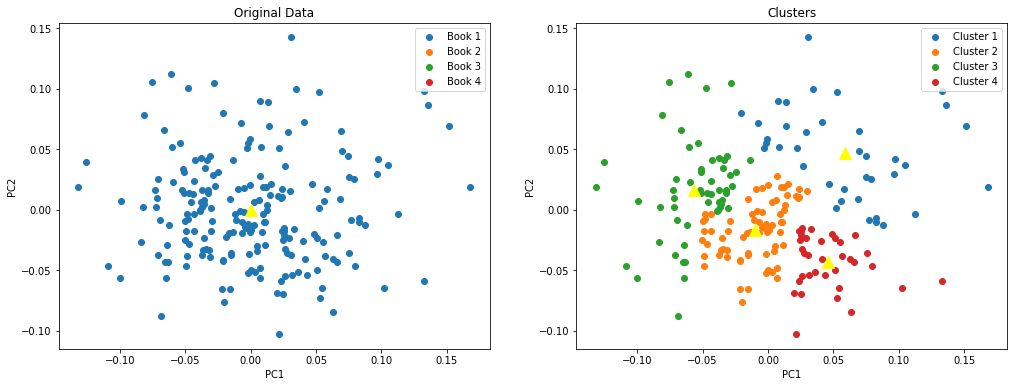

In [180]:
plot_clusters(book1_d2v, book1_agg_doc2vec_model, y[:200], 4)



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


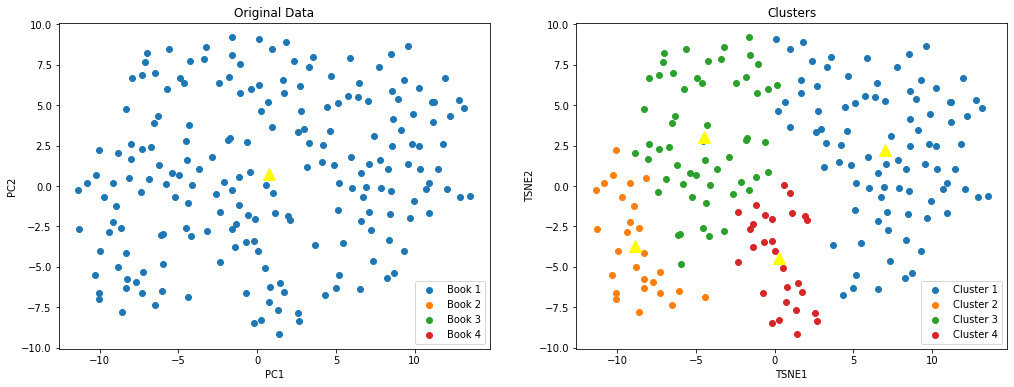

In [181]:
plot_clusters_tsne(book1_d2v, book1_agg_doc2vec_model, y[:200], 4) 



In [182]:
calc_scores(book1_d2v, book1_agg_doc2vec_model, y[:200])

Silhouette Coefficient is: 0.123
Cohen’s kappa Score is: 0.0


#### Best Model with respect to human labels is **Agg_TF-IDF**

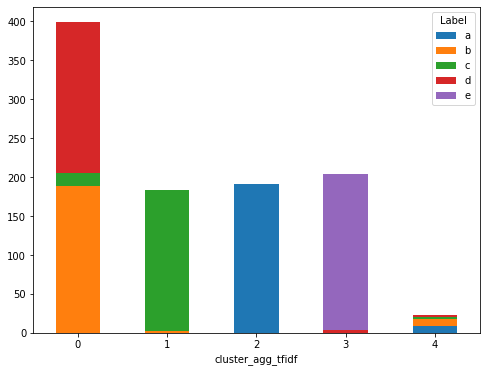

In [183]:
pd.crosstab(df_clusters.cluster_agg_tfidf, df_clusters.Label).plot.bar(figsize=(8,6), stacked=True, rot=0);

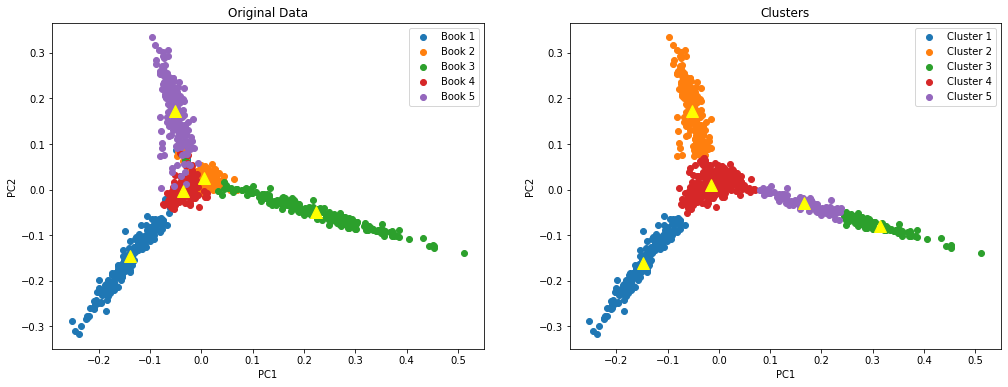

In [184]:
plot_clusters(tfidf_model, agg_tfidf_model, y)

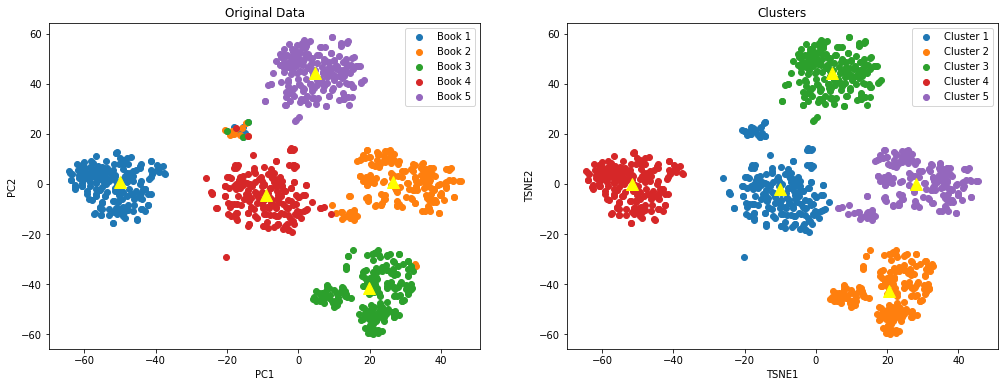

In [185]:
plot_clusters_tsne(tfidf_model, agg_tfidf_model, y) 